In [29]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s3e24/sample_submission.csv
/kaggle/input/playground-series-s3e24/train.csv
/kaggle/input/playground-series-s3e24/test.csv


# Importing Libraries and Data

First we import all the necessary libraries and data

In [30]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

In [31]:
train = pd.read_csv('/kaggle/input/playground-series-s3e24/train.csv')
train.head(10)

,id,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,...,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
0,0,55,165,60,81.0,0.5,0.6,1,1,135,...,40,75,16.5,1,1.0,22,25,27,0,1
1,1,70,165,65,89.0,0.6,0.7,2,2,146,...,57,126,16.2,1,1.1,27,23,37,1,0
2,2,20,170,75,81.0,0.4,0.5,1,1,118,...,45,93,17.4,1,0.8,27,31,53,0,1
3,3,35,180,95,105.0,1.5,1.2,1,1,131,...,38,102,15.9,1,1.0,20,27,30,1,0
4,4,30,165,60,80.5,1.5,1.0,1,1,121,...,44,93,15.4,1,0.8,19,13,17,0,1
5,5,50,170,55,51.0,1.2,1.2,1,1,146,...,31,99,15.9,1,0.7,24,42,119,1,1
6,6,45,160,55,69.0,1.5,1.2,1,1,150,...,69,122,13.0,1,0.7,17,12,16,0,0
7,7,55,155,60,84.5,0.7,0.9,1,1,137,...,51,198,14.5,1,0.7,16,15,16,0,0
8,8,40,165,70,89.0,0.7,1.0,1,1,130,...,59,150,15.7,1,0.9,24,21,31,0,1
9,9,40,155,50,73.0,1.5,1.5,1,1,105,...,55,122,13.2,1,0.7,22,16,14,0,0


# Data Exploratory

Now we need to have a quick look of the data to understand it. With a better understanding of the data, we can process it better later.

In [32]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159256 entries, 0 to 159255
Data columns (total 24 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   id                   159256 non-null  int64  
 1   age                  159256 non-null  int64  
 2   height(cm)           159256 non-null  int64  
 3   weight(kg)           159256 non-null  int64  
 4   waist(cm)            159256 non-null  float64
 5   eyesight(left)       159256 non-null  float64
 6   eyesight(right)      159256 non-null  float64
 7   hearing(left)        159256 non-null  int64  
 8   hearing(right)       159256 non-null  int64  
 9   systolic             159256 non-null  int64  
 10  relaxation           159256 non-null  int64  
 11  fasting blood sugar  159256 non-null  int64  
 12  Cholesterol          159256 non-null  int64  
 13  triglyceride         159256 non-null  int64  
 14  HDL                  159256 non-null  int64  
 15  LDL              

We try to get the columns for both numerical and categorical

In [33]:
num_var = train.columns.drop(['id', 'hearing(left)', 'hearing(right)', 'dental caries', 'Urine protein']).tolist()
cat_var = train[['hearing(left)', 'hearing(right)', 'dental caries', 'Urine protein', 'smoking', 'id']].columns.tolist()
ind_var = train.columns.drop(['id', 'smoking']).tolist()
dep_var = train[['smoking']].columns.tolist()

## Smoker to Non Smoker Ratio

We need to look at our dependent variable, to see the distribution. We might need to do some data augmentation later if the data is not balanced.

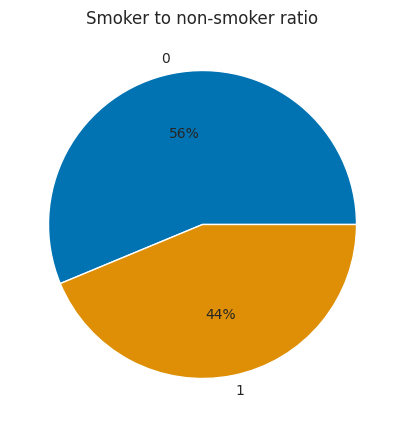

In [34]:
label, counts = np.unique(train['smoking'].values, return_counts=True)
sns.set_style("whitegrid")
sns.set_palette("colorblind")
fig = plt.figure(figsize=(5, 5))
plt.title('Smoker to non-smoker ratio')
plt.pie(counts, labels=label, autopct='%.0f%%');

## Categorical Variable

Now we look at the categorical variable

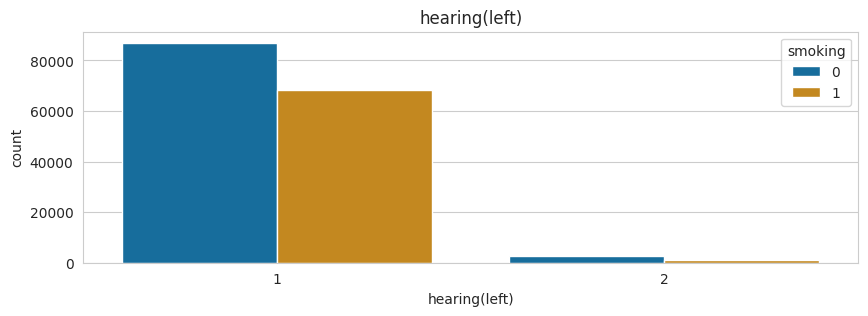

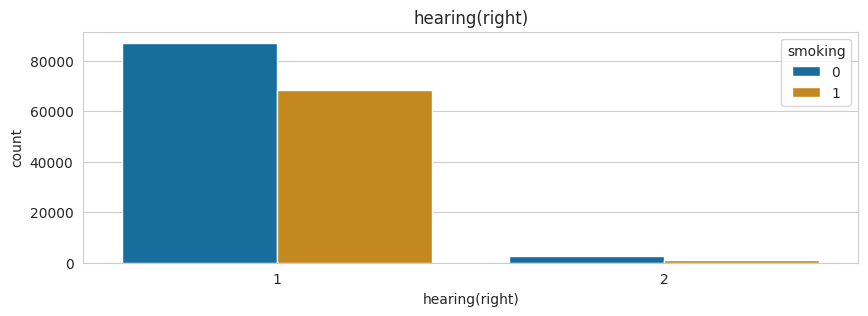

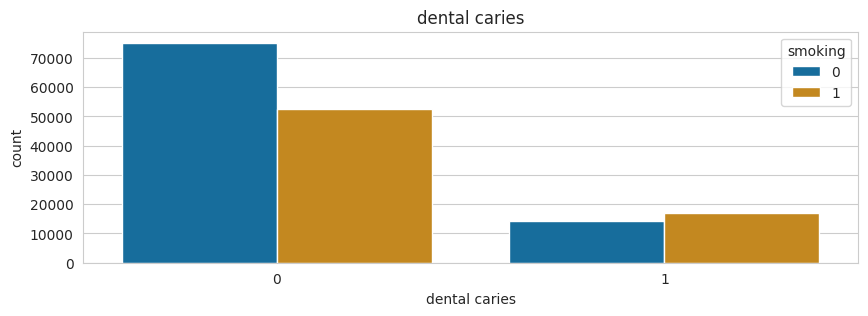

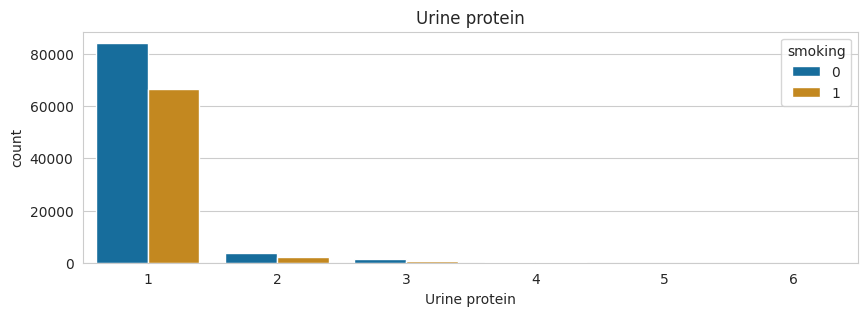

In [35]:
for feat in cat_var[:-2]:
    fig = plt.figure(figsize=(10,3))
    sns.countplot(x=feat, data=train, hue='smoking') 
    plt.title(feat)
    plt.show()

### Alternative Visualization

We can also use another way of looking at the categorical data, using the heatmap, and view it like a confusion matrix. Not really usable for data with very high cardinality

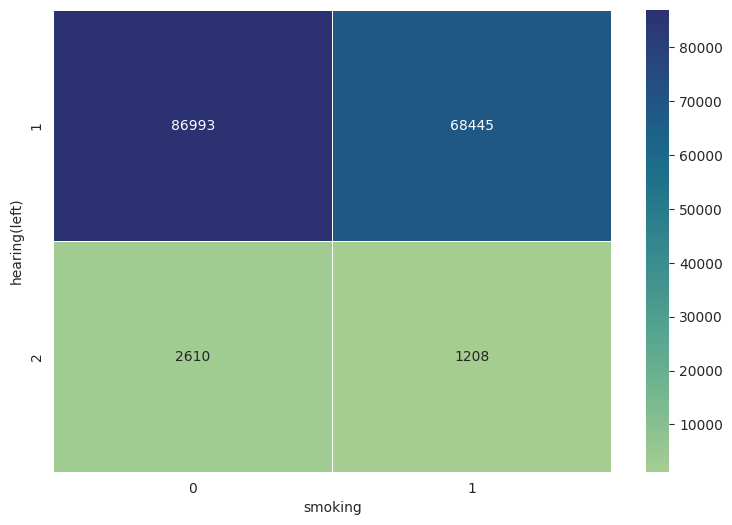

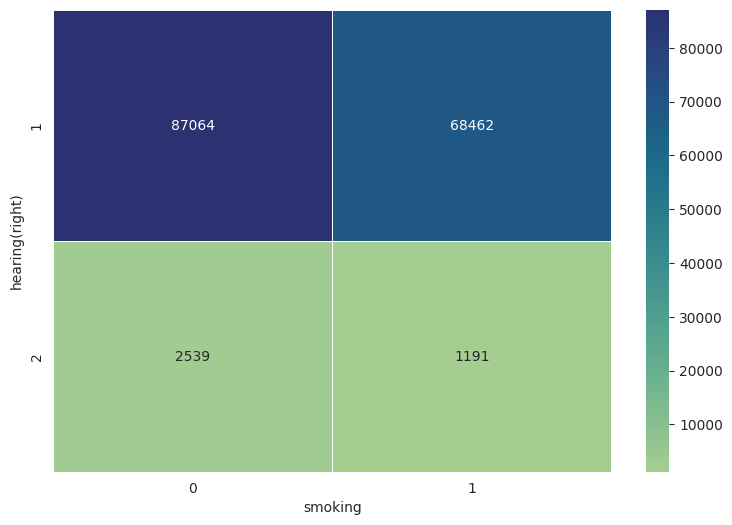

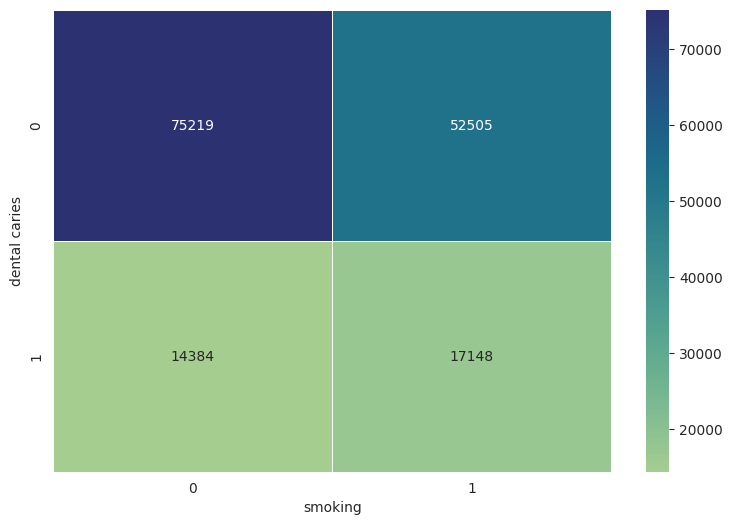

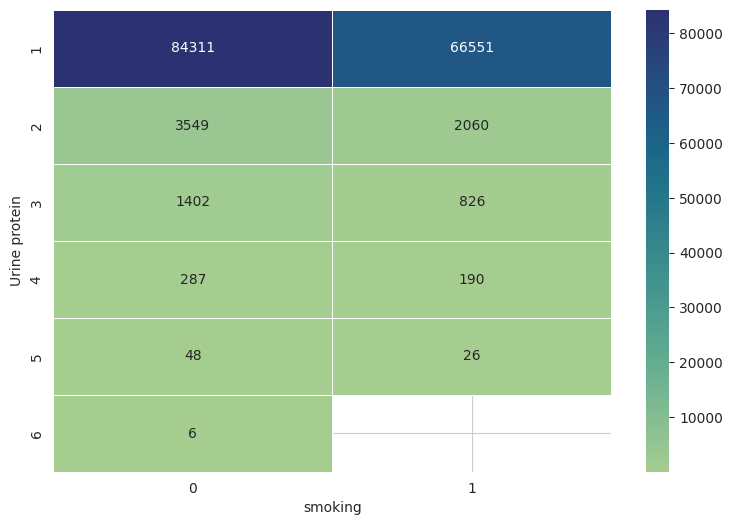

In [36]:
for feat in cat_var[:-2]:
    summary = pd.pivot_table(data=train[cat_var], index=feat, columns='smoking', aggfunc='count', values = 'id')
    
    # Draw a heatmap with the numeric values in each cell
    fig, ax = plt.subplots(figsize=(9, 6))
    sns.heatmap(summary, annot=True, fmt=".0f", cmap="crest", linewidths=.5, ax=ax)

## Numerical Variable

Now, let's look at the numerical variable

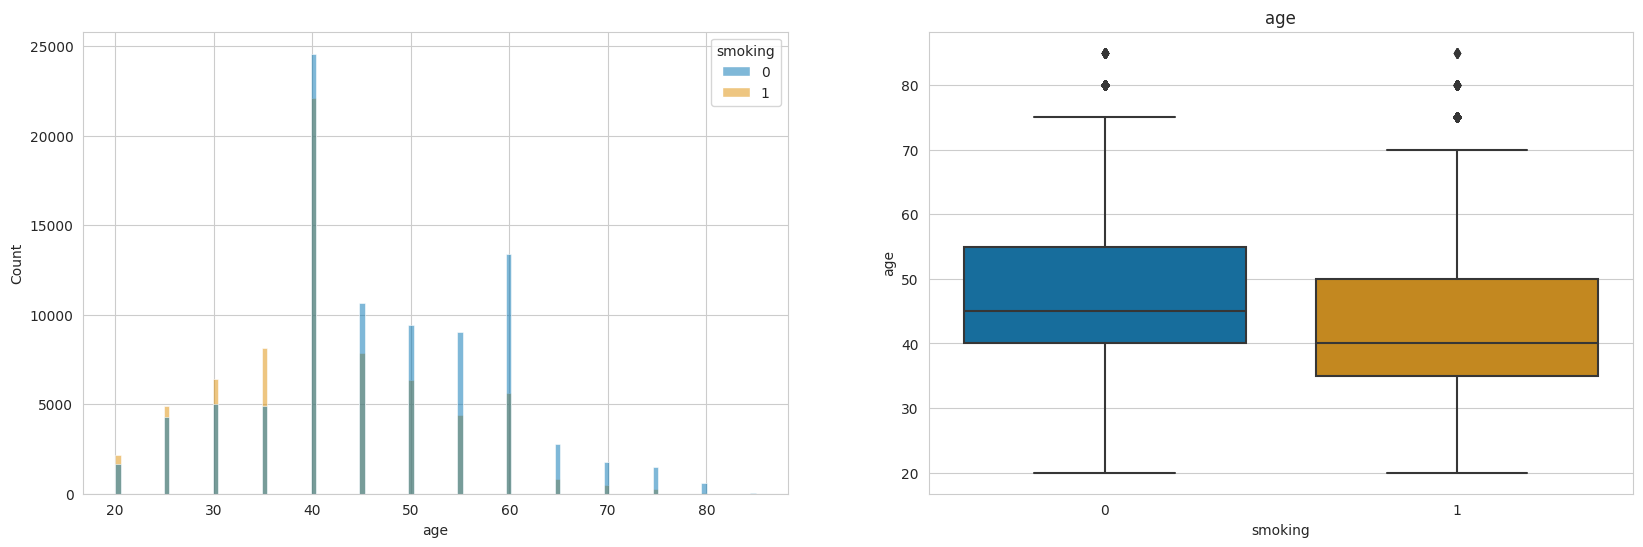

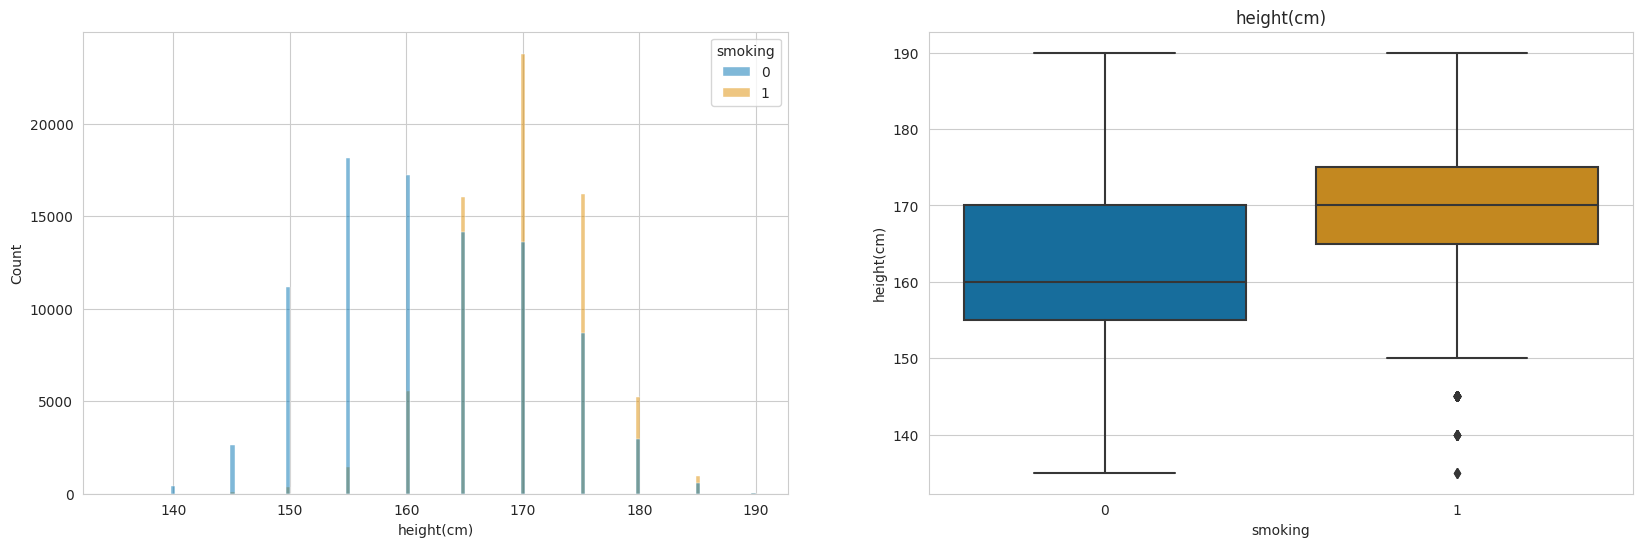

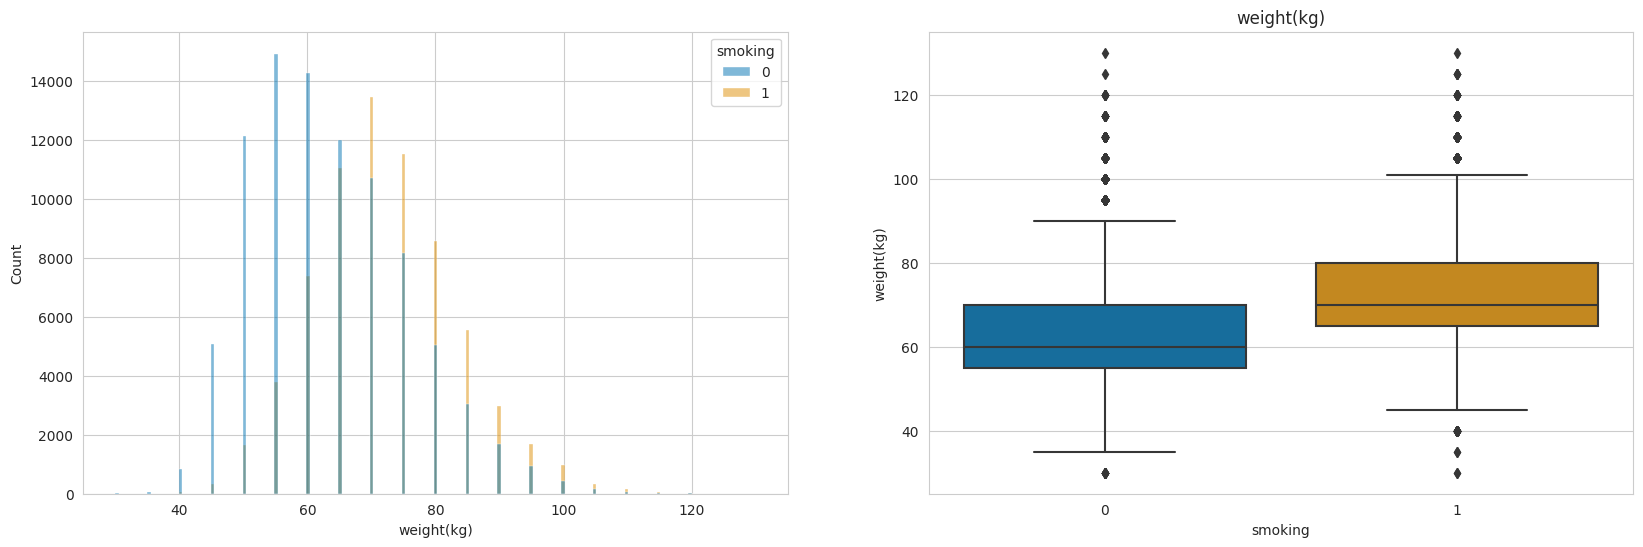

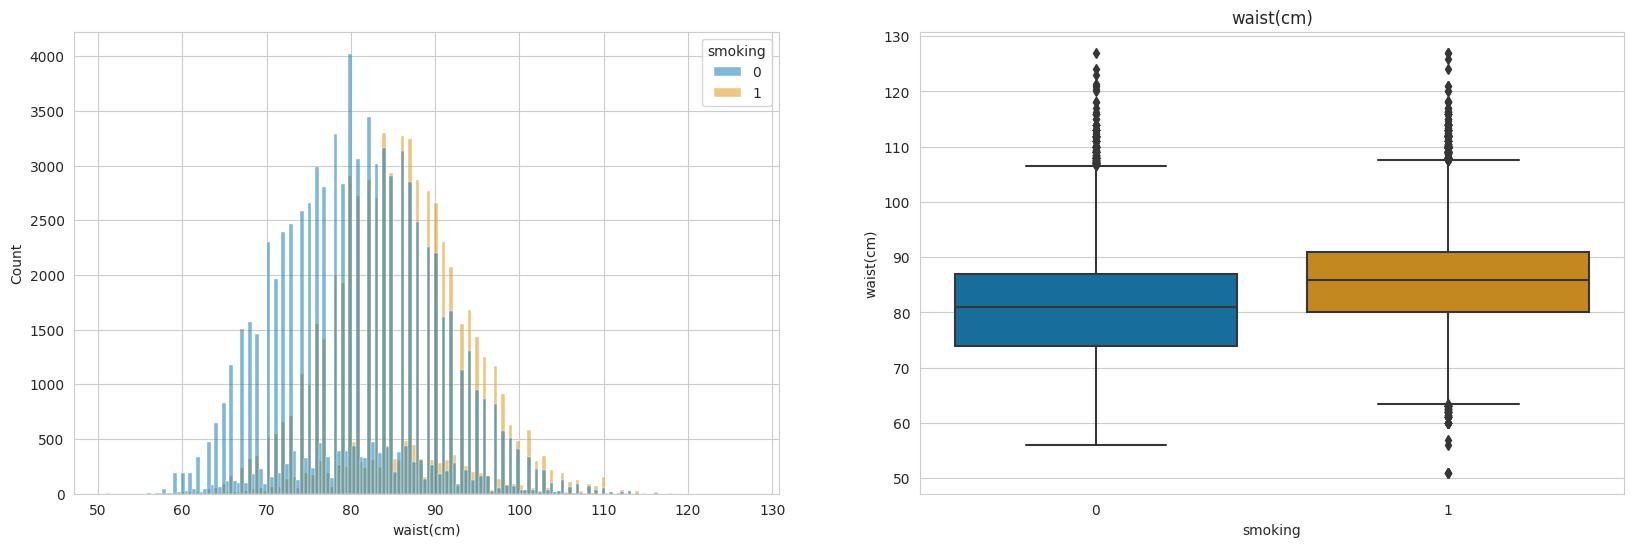

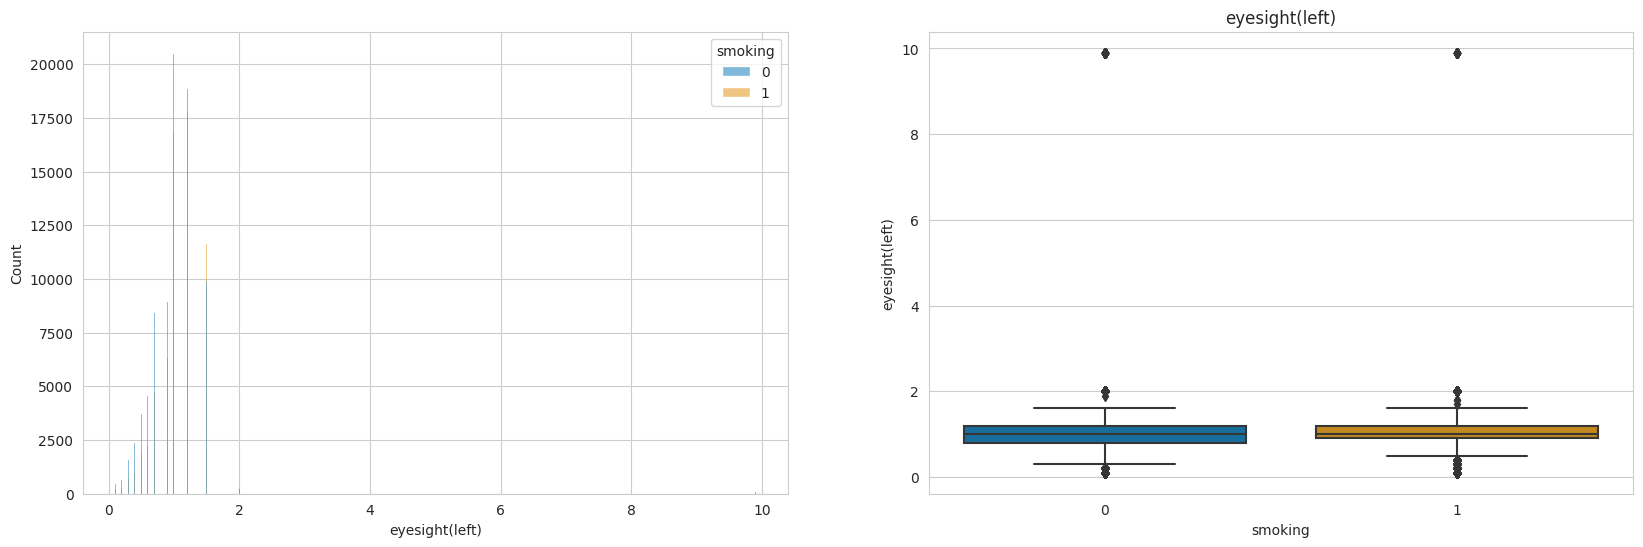

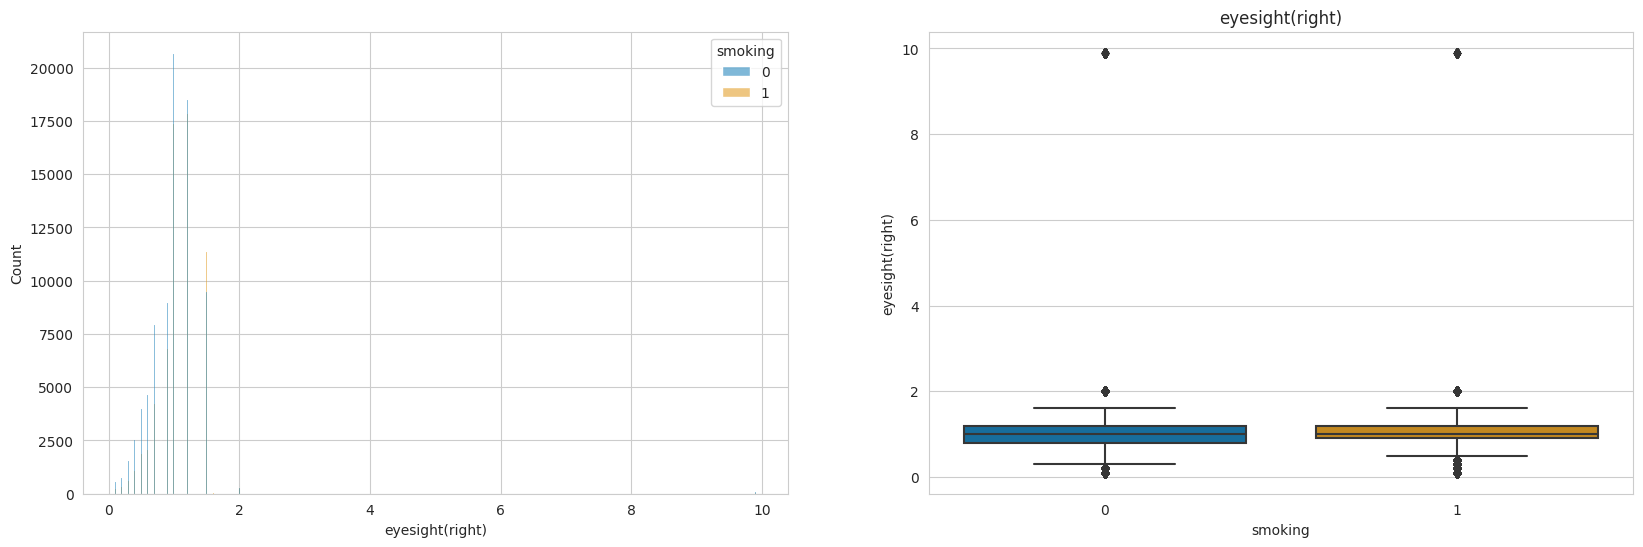

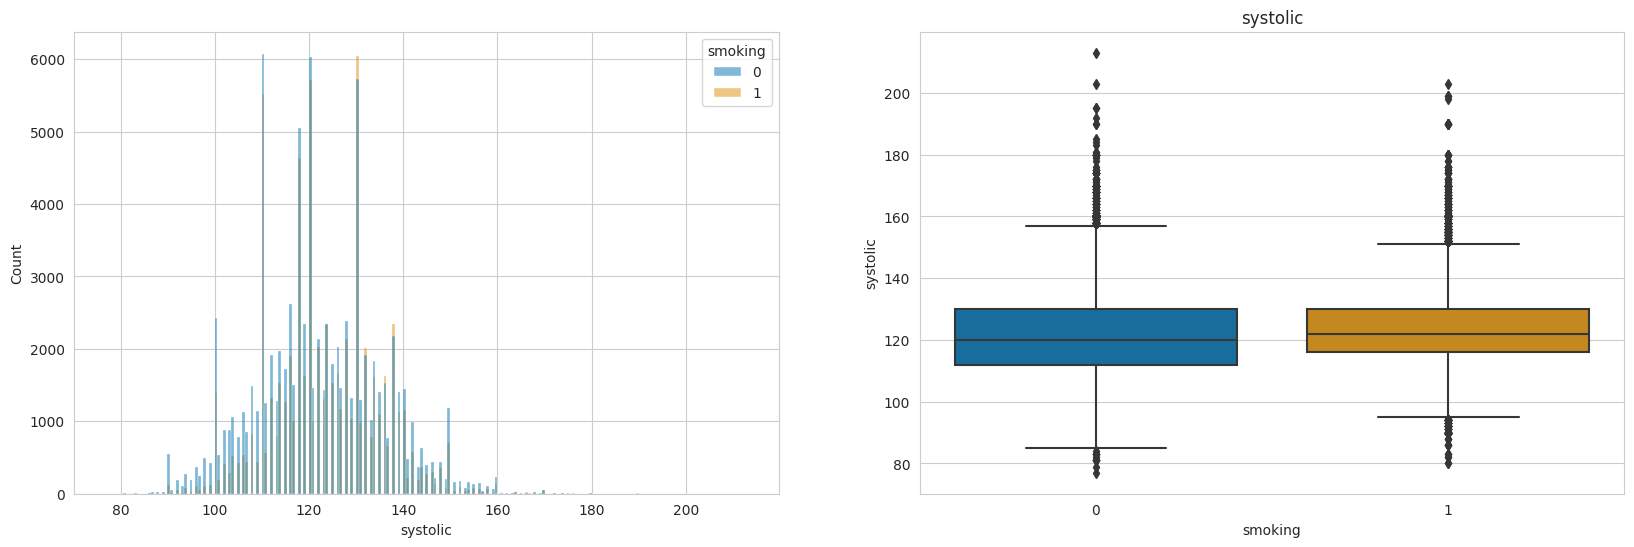

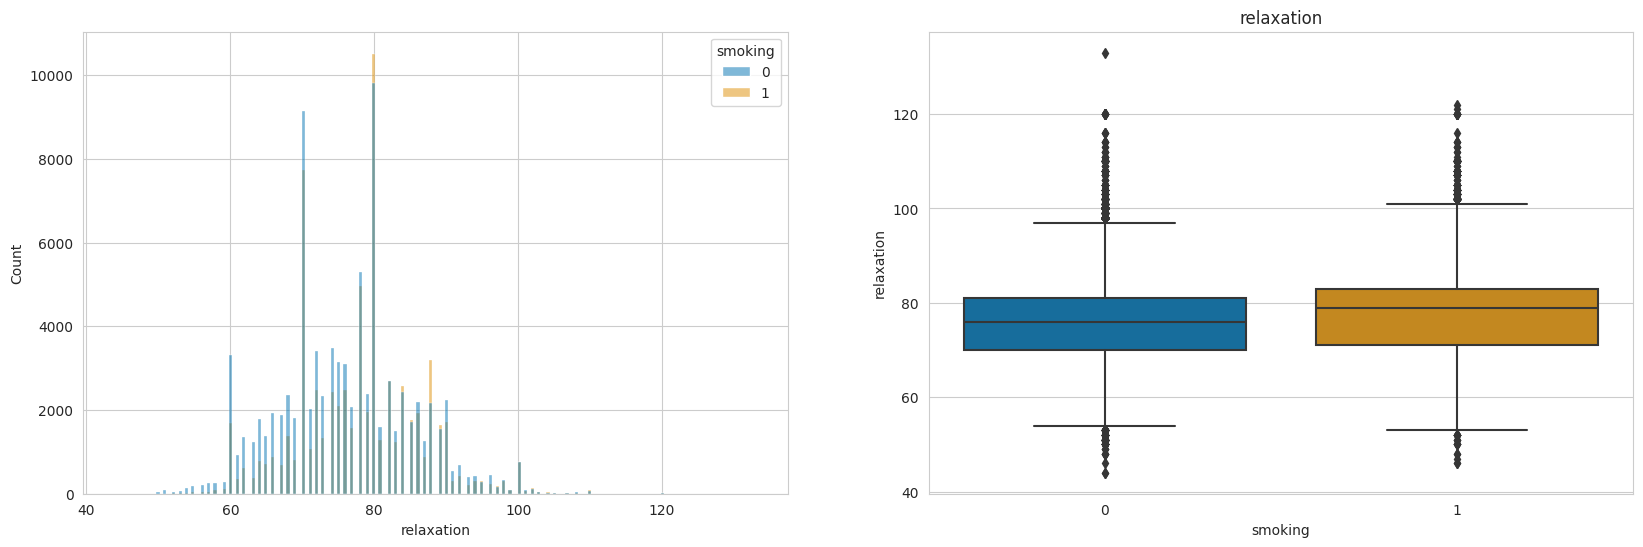

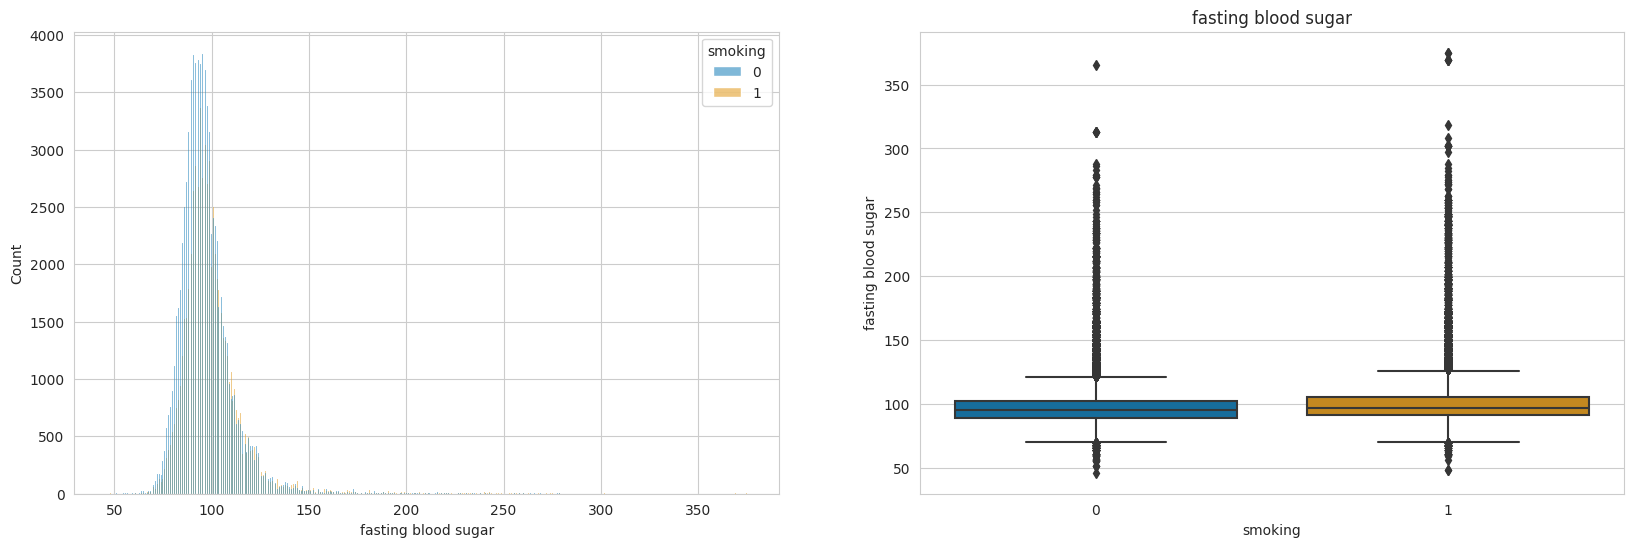

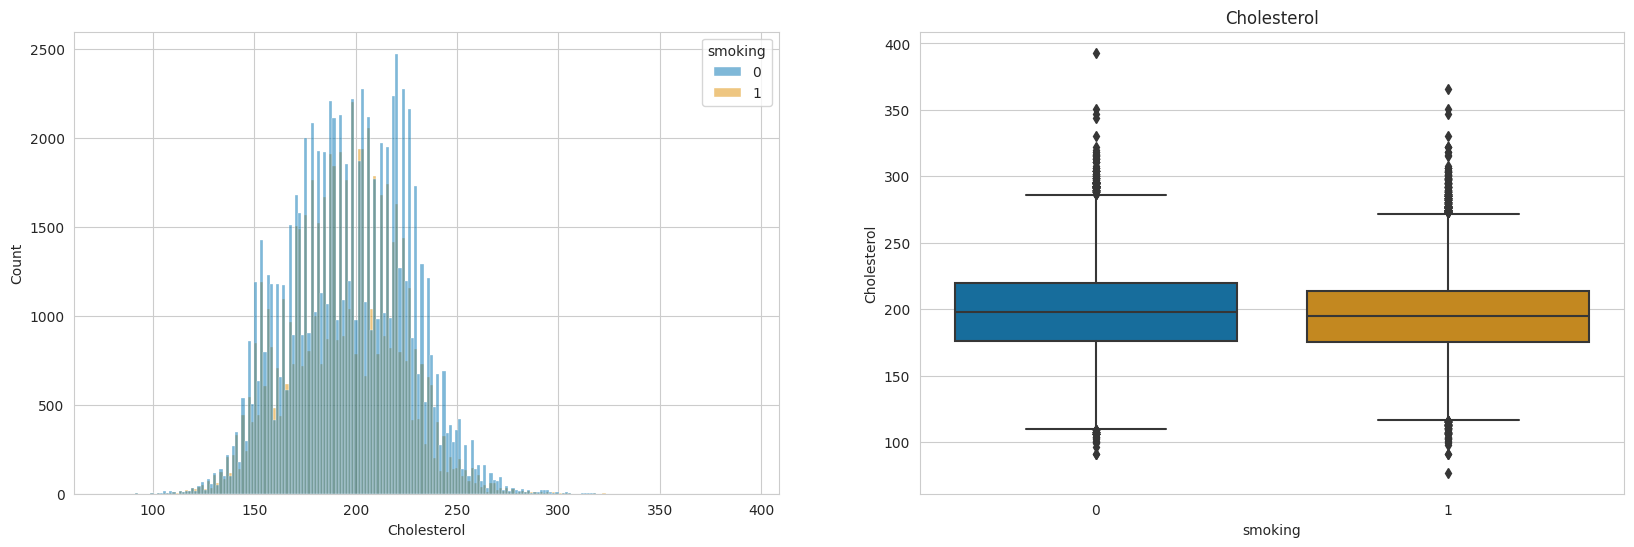

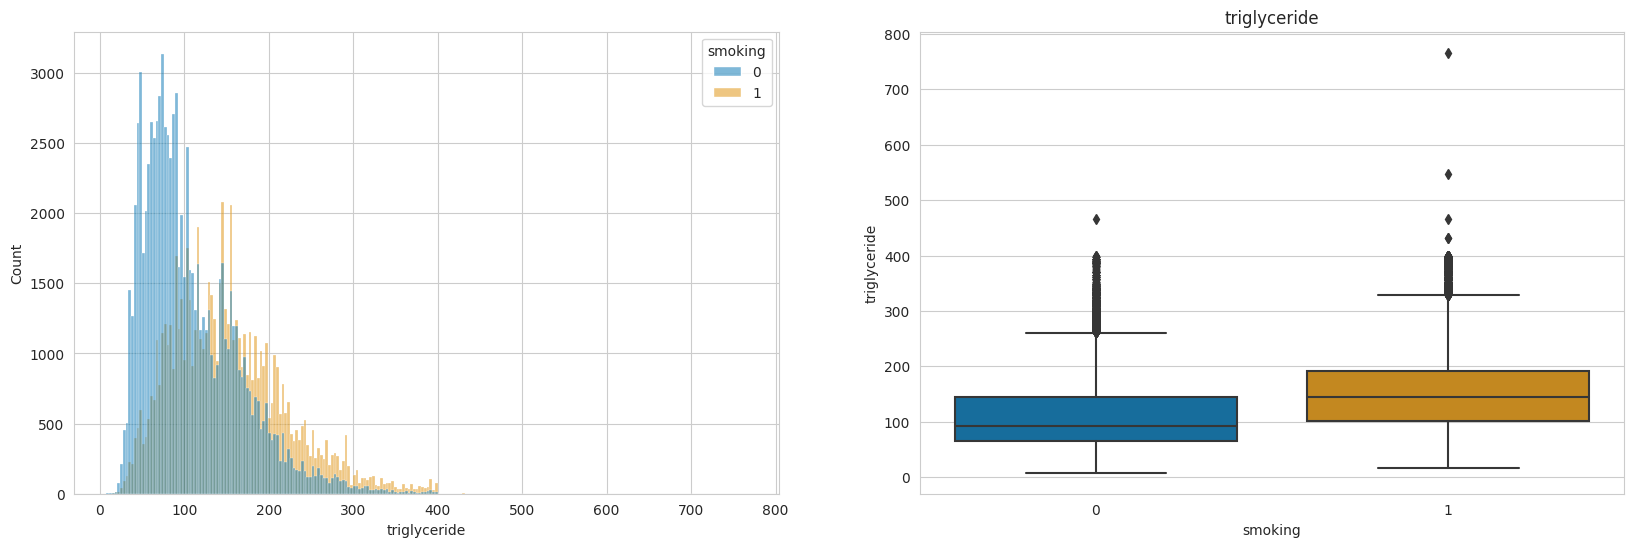

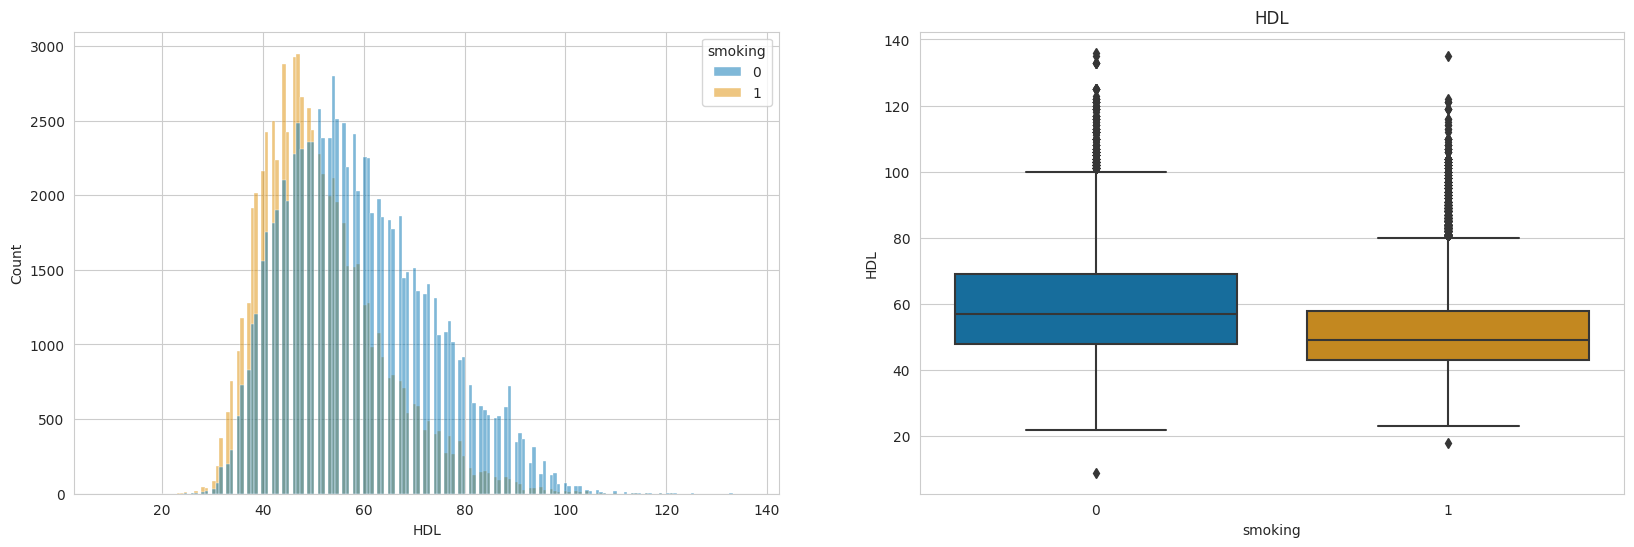

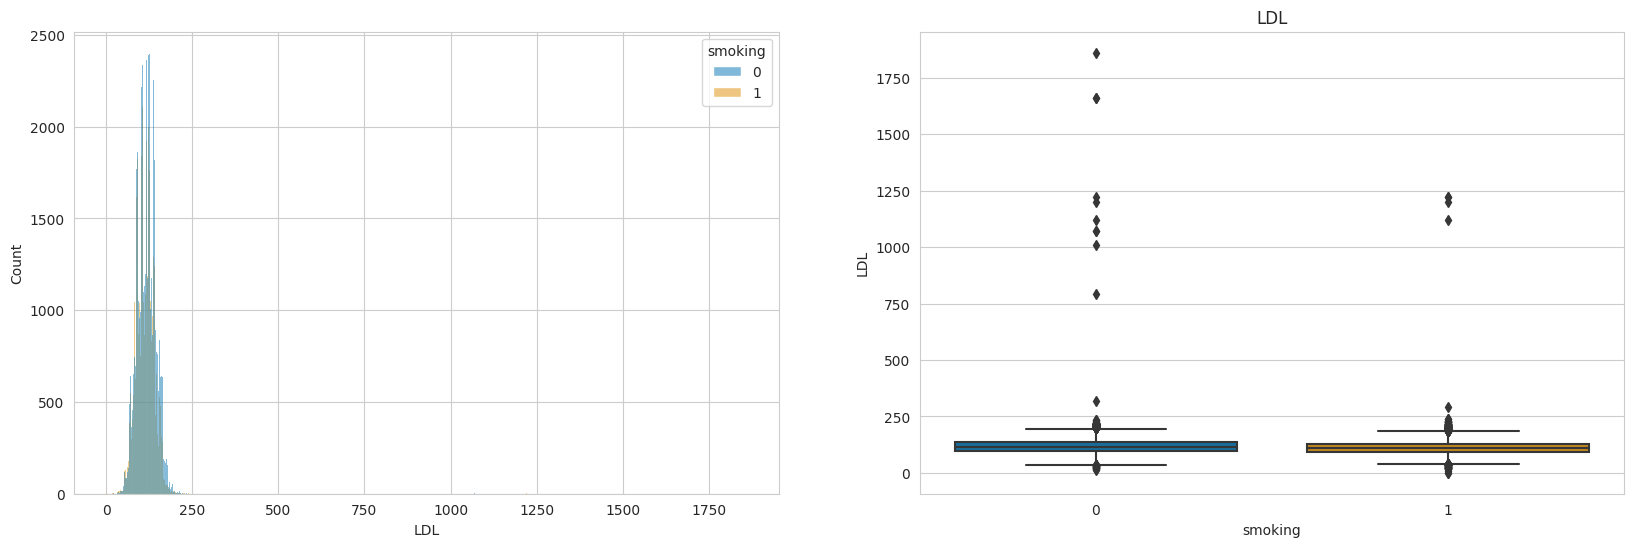

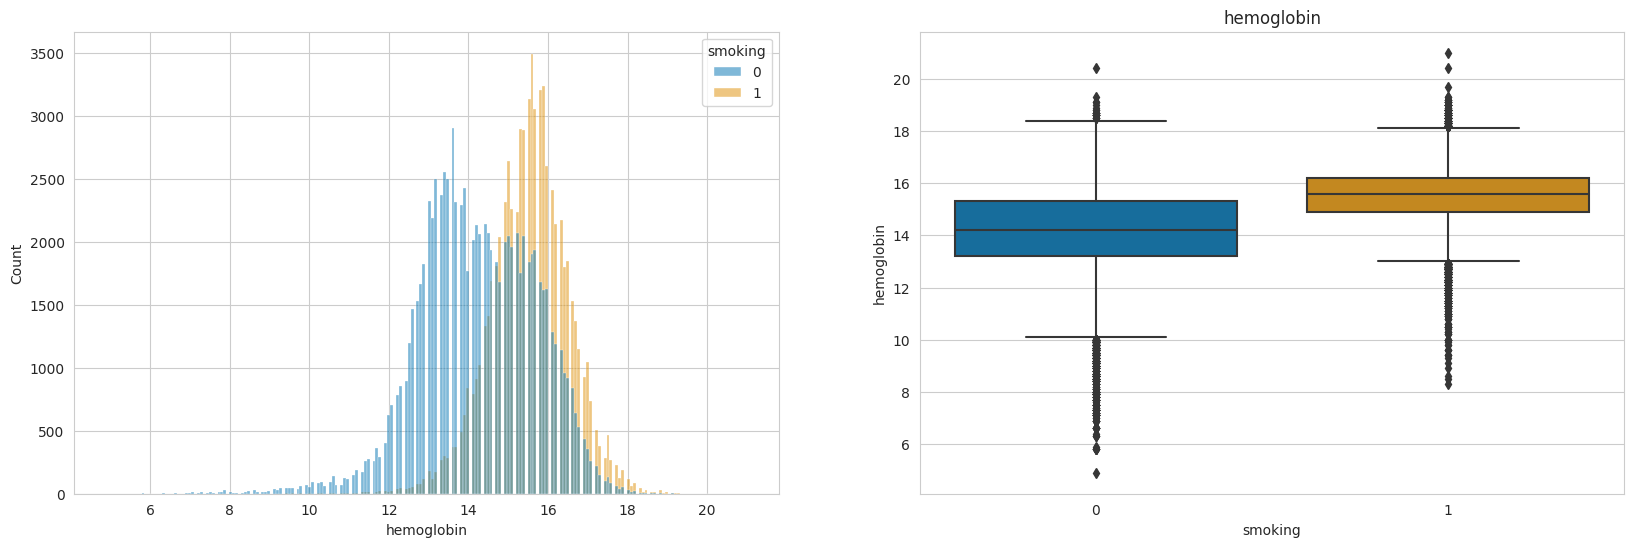

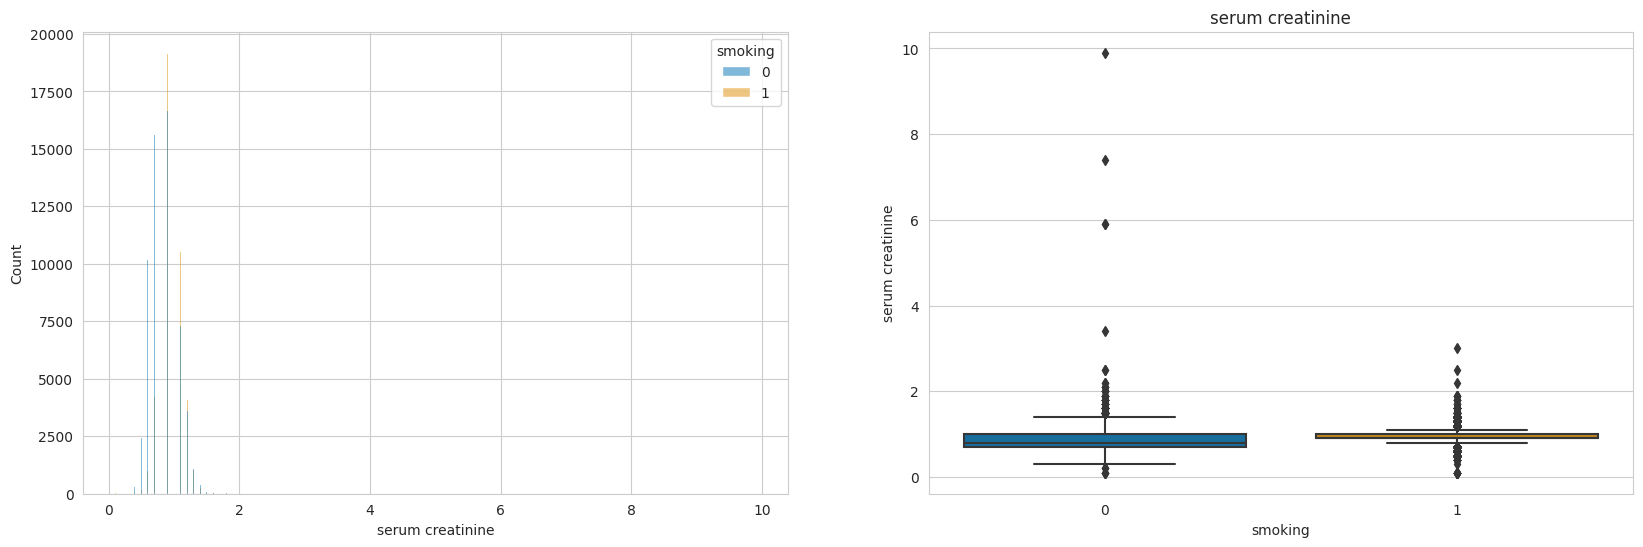

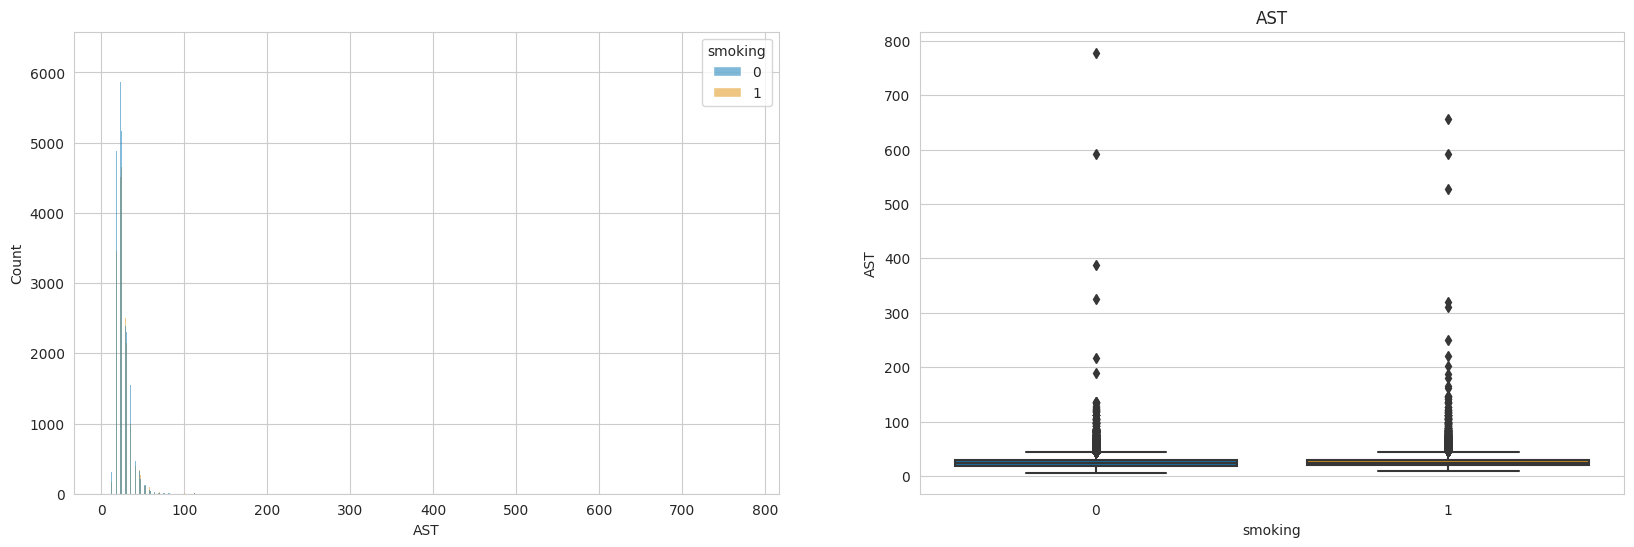

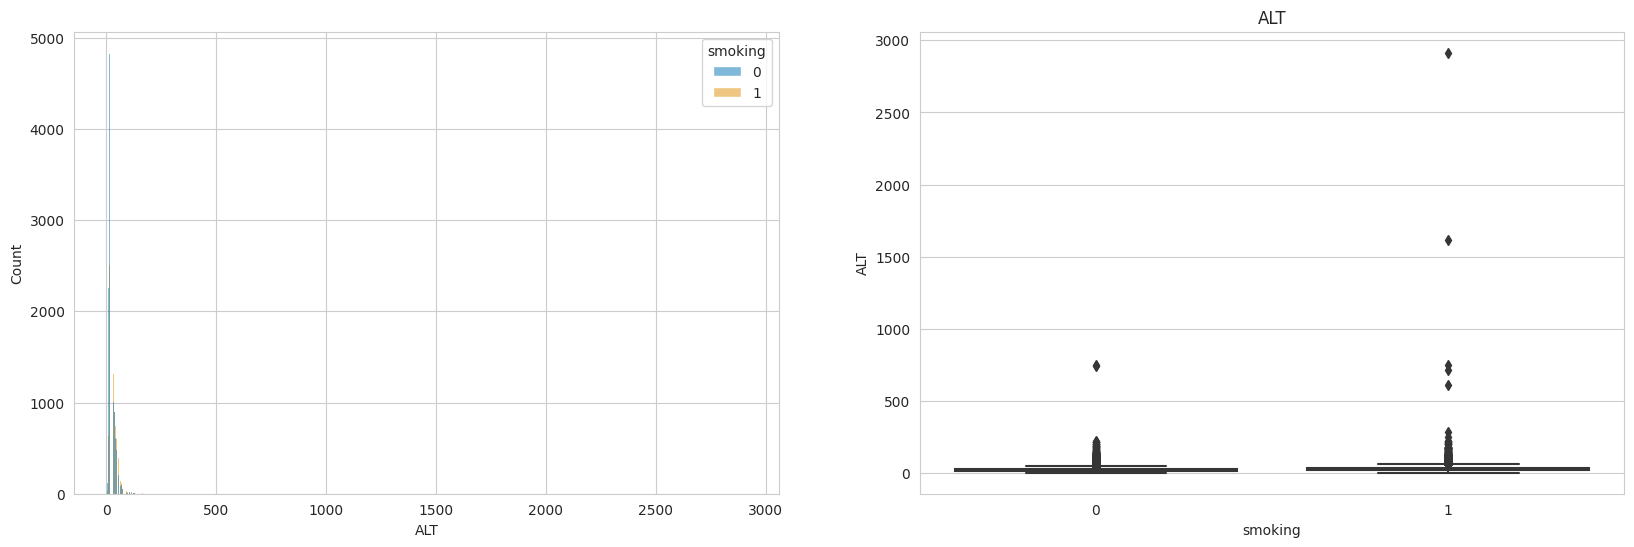

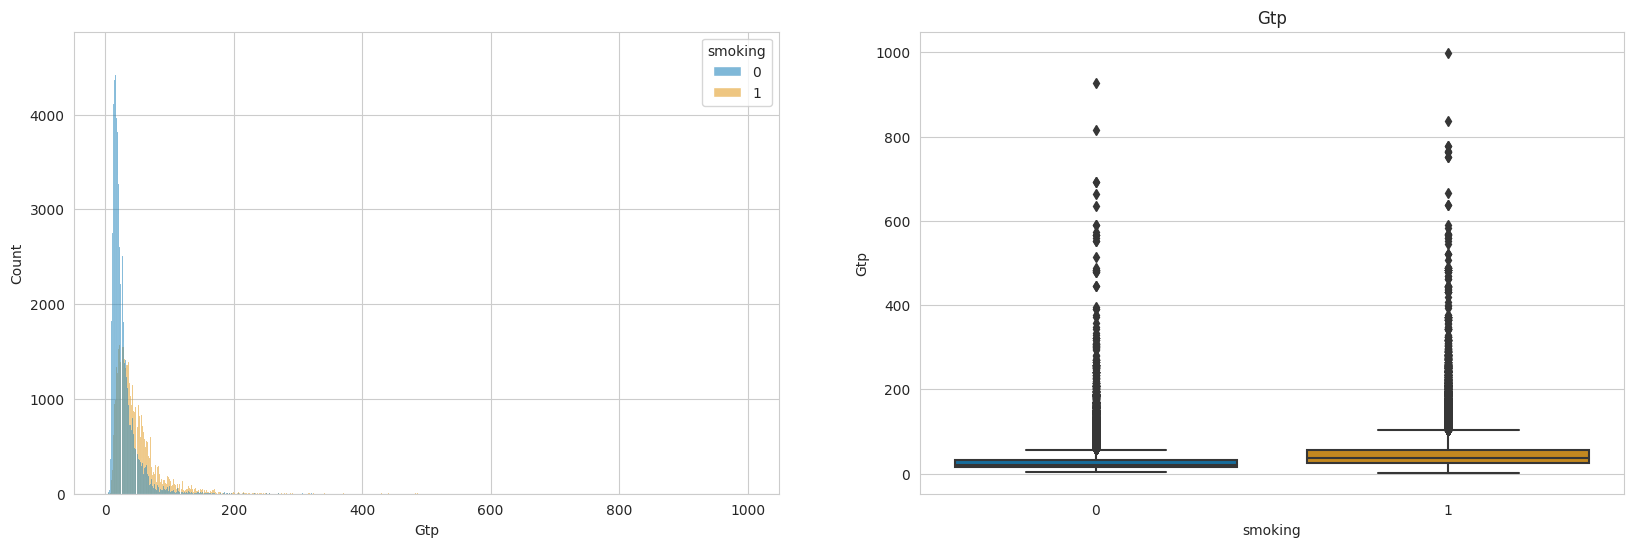

In [37]:
for feat in num_var[:-1]:
    fig, ax = plt.subplots(1, 2, figsize = (20, 6))
    sns.histplot(ax = ax[0], data = train, x = feat, hue = 'smoking')
    sns.boxplot(ax = ax[1], data= train, x = 'smoking', y = feat);
    plt.title(feat)
    plt.show()

### Small data cleaning

In [38]:
# Remove the super outliers
train.drop(train[train['eyesight(left)'] > 8].index, inplace=True)
train.drop(train[train['eyesight(right)'] > 8].index, inplace=True)
train.drop(train[train['triglyceride'] > 700].index, inplace=True)
train.drop(train[train['serum creatinine'] > 4].index, inplace=True)
train.drop(train[train['ALT'] > 1500].index, inplace=True)
#train.drop(train[train['HDL'] > 350].index, inplace=True)
train.drop(train[train['LDL'] > 1500].index, inplace=True)

train

,id,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,...,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
0,0,55,165,60,81.0,0.5,0.6,1,1,135,...,40,75,16.5,1,1.0,22,25,27,0,1
1,1,70,165,65,89.0,0.6,0.7,2,2,146,...,57,126,16.2,1,1.1,27,23,37,1,0
2,2,20,170,75,81.0,0.4,0.5,1,1,118,...,45,93,17.4,1,0.8,27,31,53,0,1
3,3,35,180,95,105.0,1.5,1.2,1,1,131,...,38,102,15.9,1,1.0,20,27,30,1,0
4,4,30,165,60,80.5,1.5,1.0,1,1,121,...,44,93,15.4,1,0.8,19,13,17,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159251,159251,40,155,45,69.0,1.5,2.0,1,1,127,...,72,159,14.5,1,0.8,25,26,13,0,0
159252,159252,50,155,75,82.0,1.0,1.0,1,1,120,...,64,108,14.5,1,0.6,21,20,18,0,0
159253,159253,40,160,50,66.0,1.5,1.0,1,1,114,...,87,93,10.9,1,0.6,15,9,12,0,0
159254,159254,50,165,75,92.0,1.2,1.0,1,1,121,...,55,80,14.4,1,1.1,22,17,37,0,1


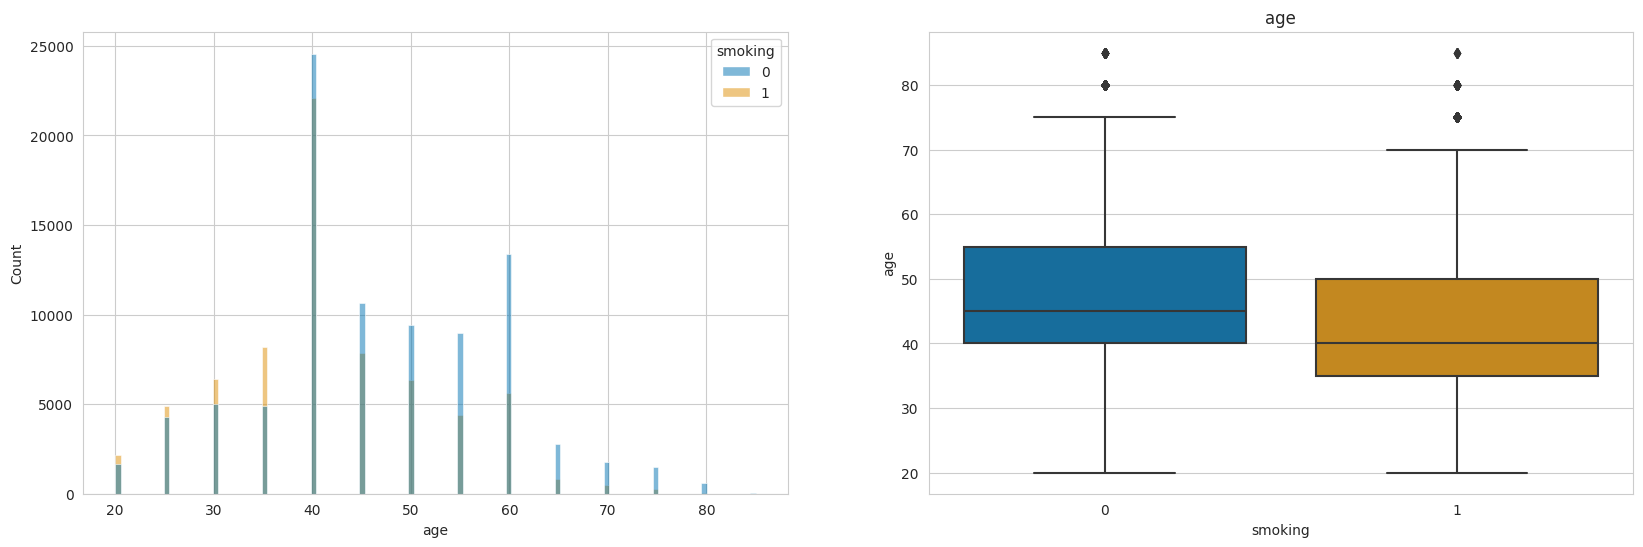

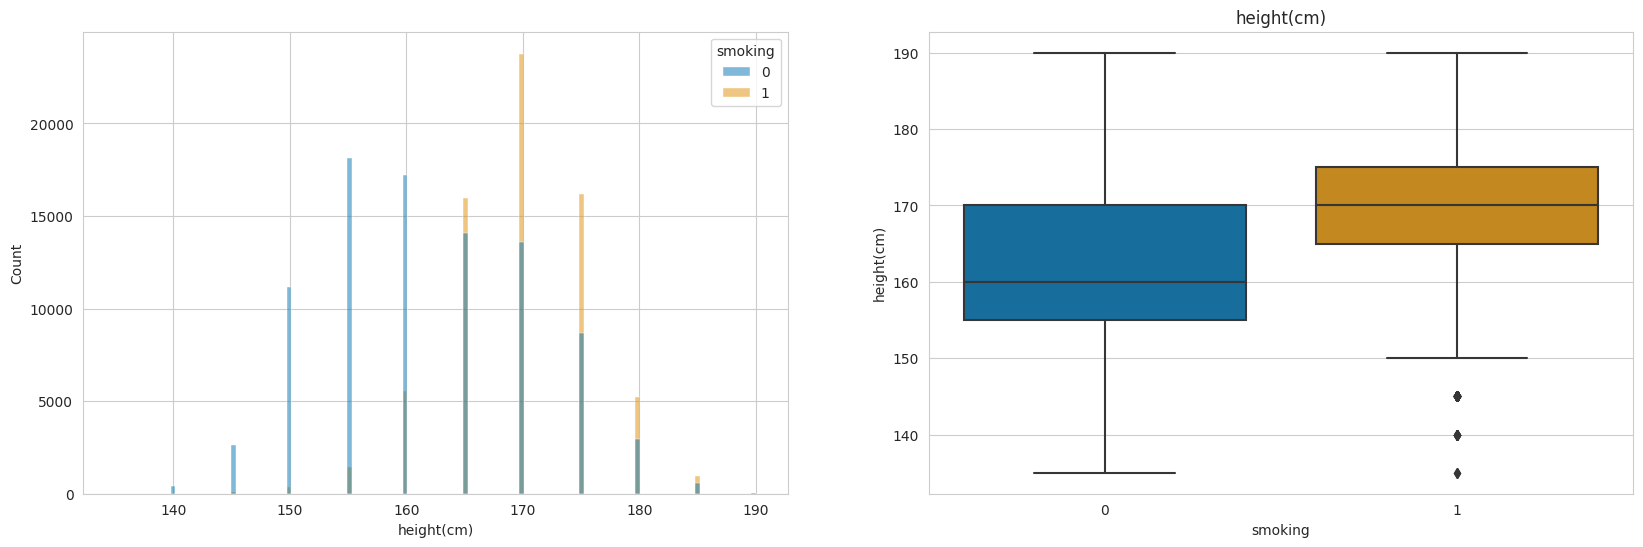

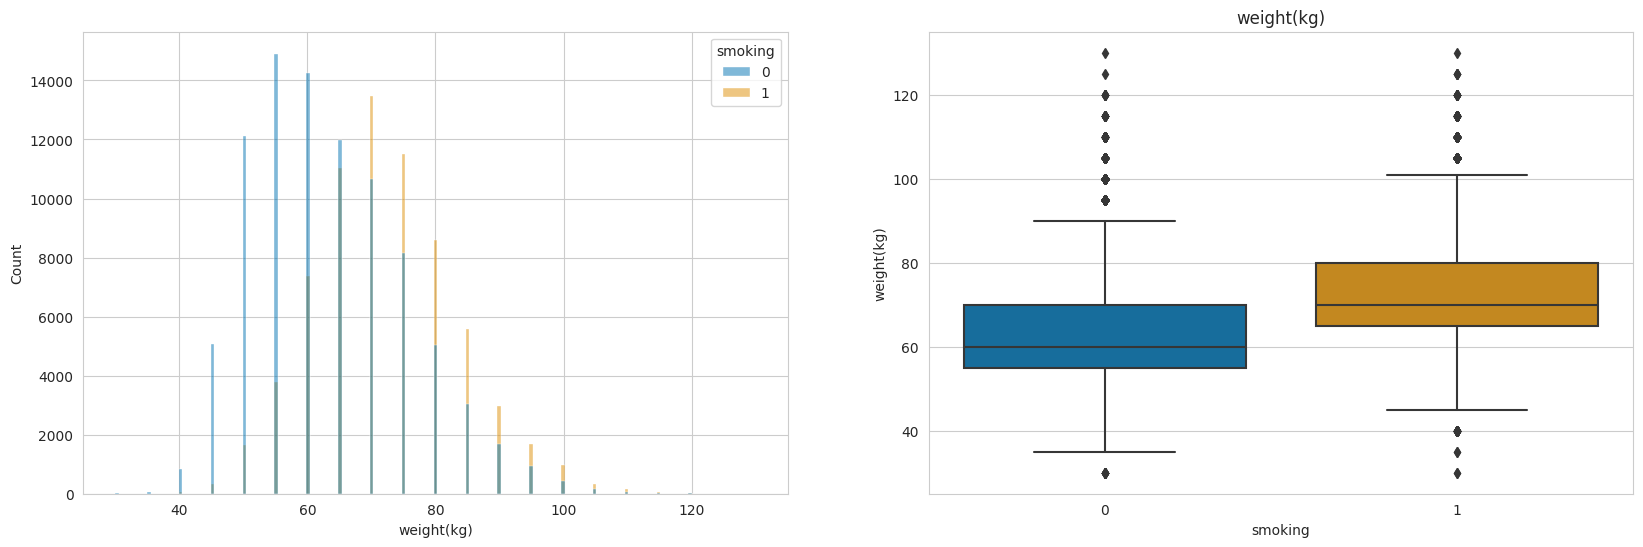

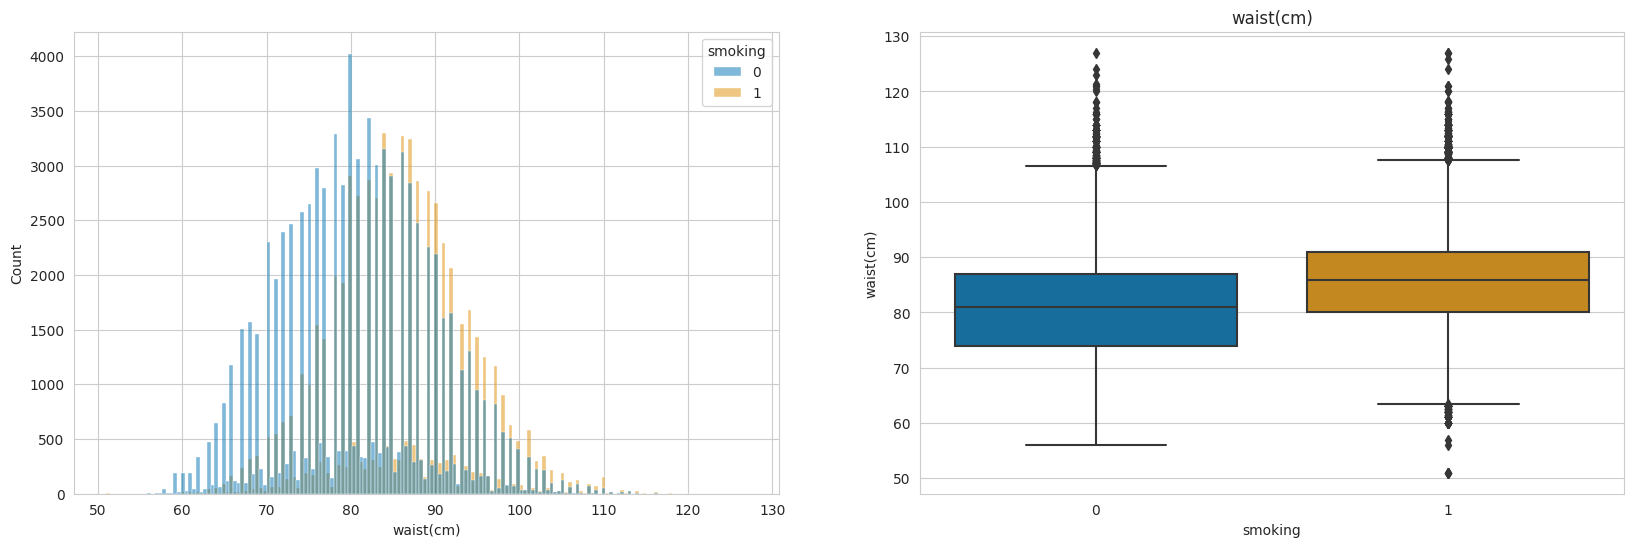

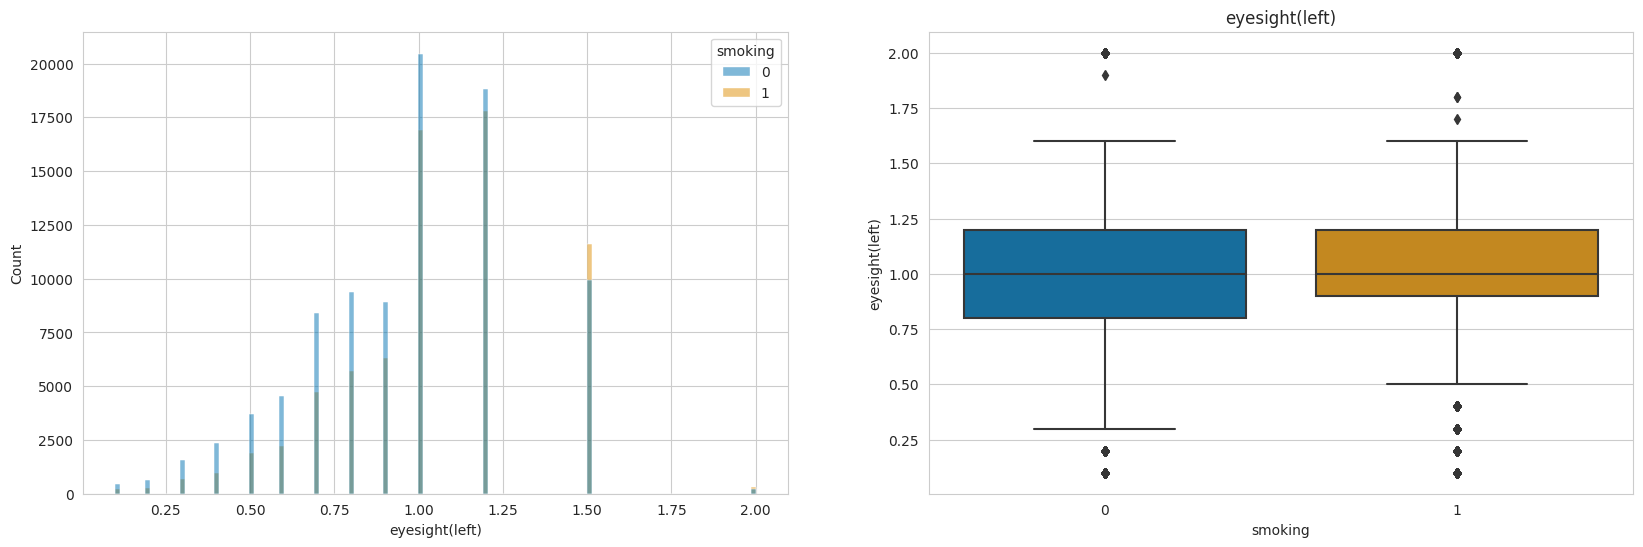

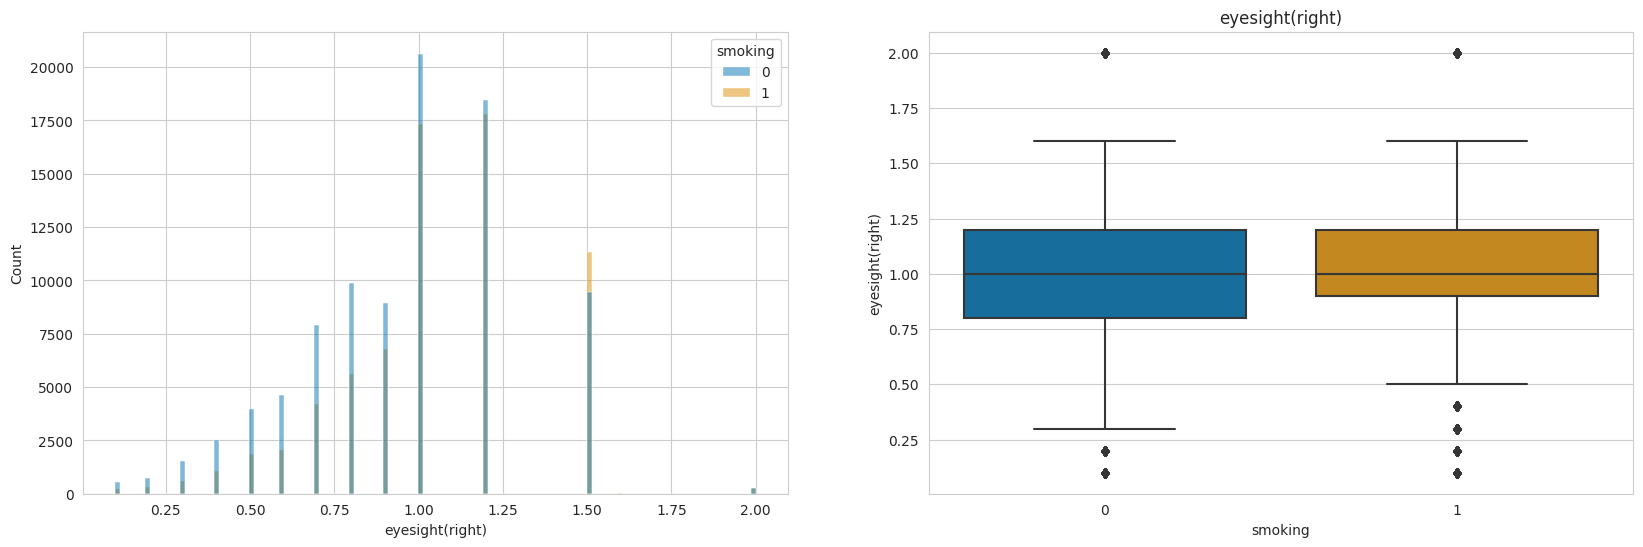

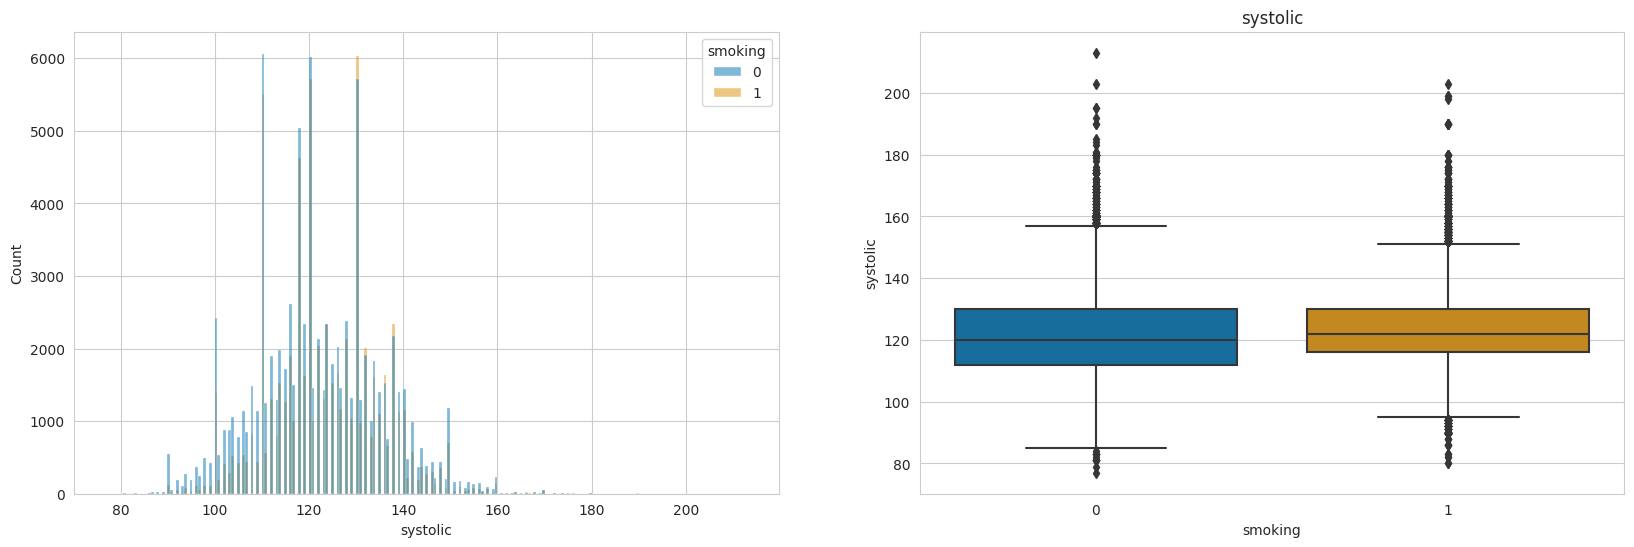

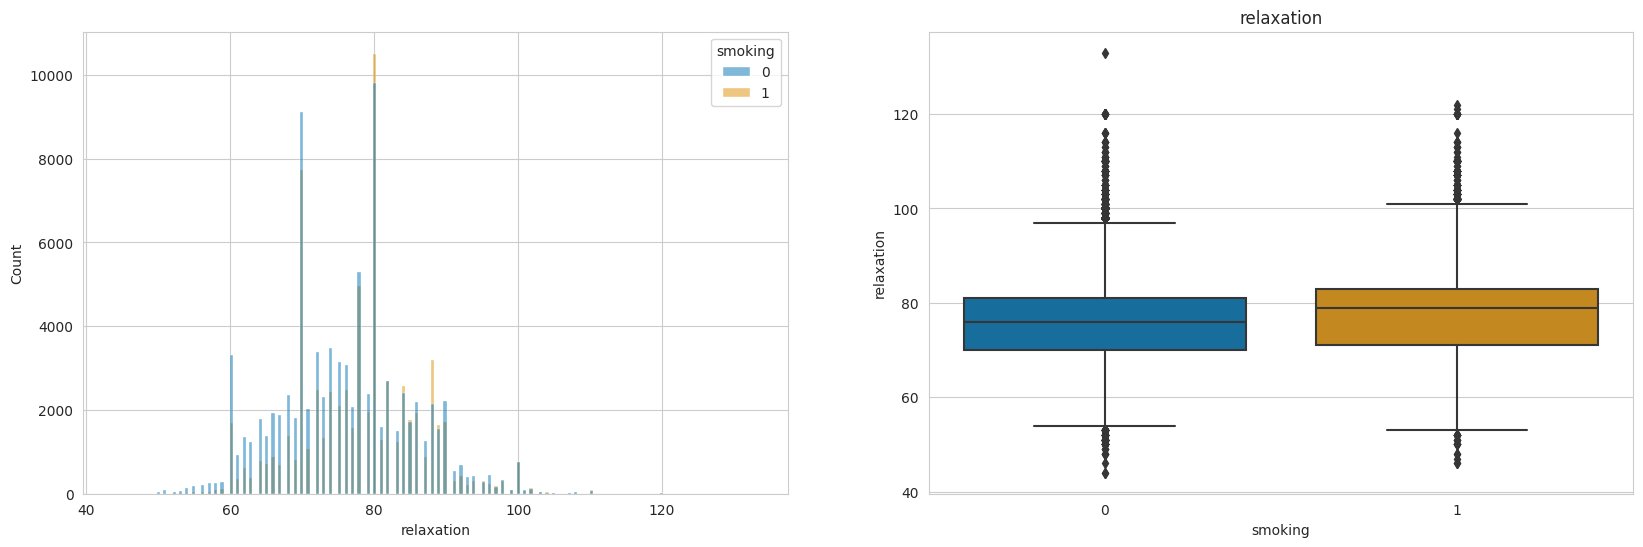

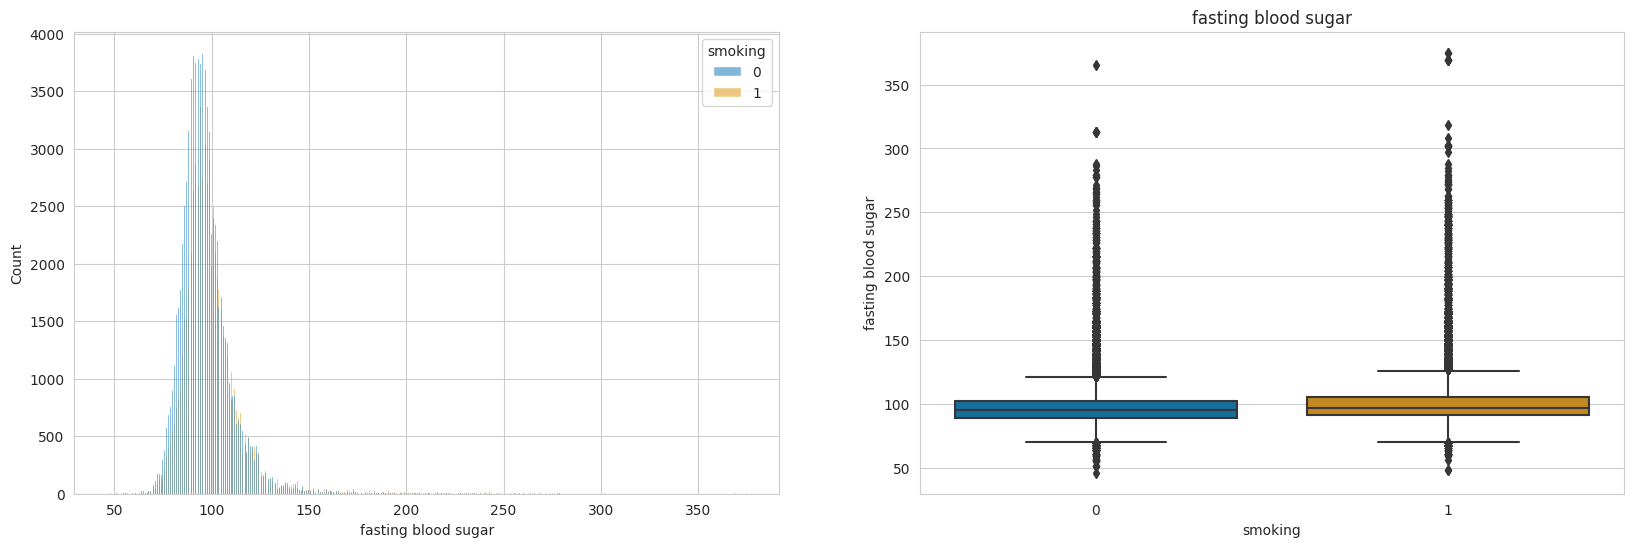

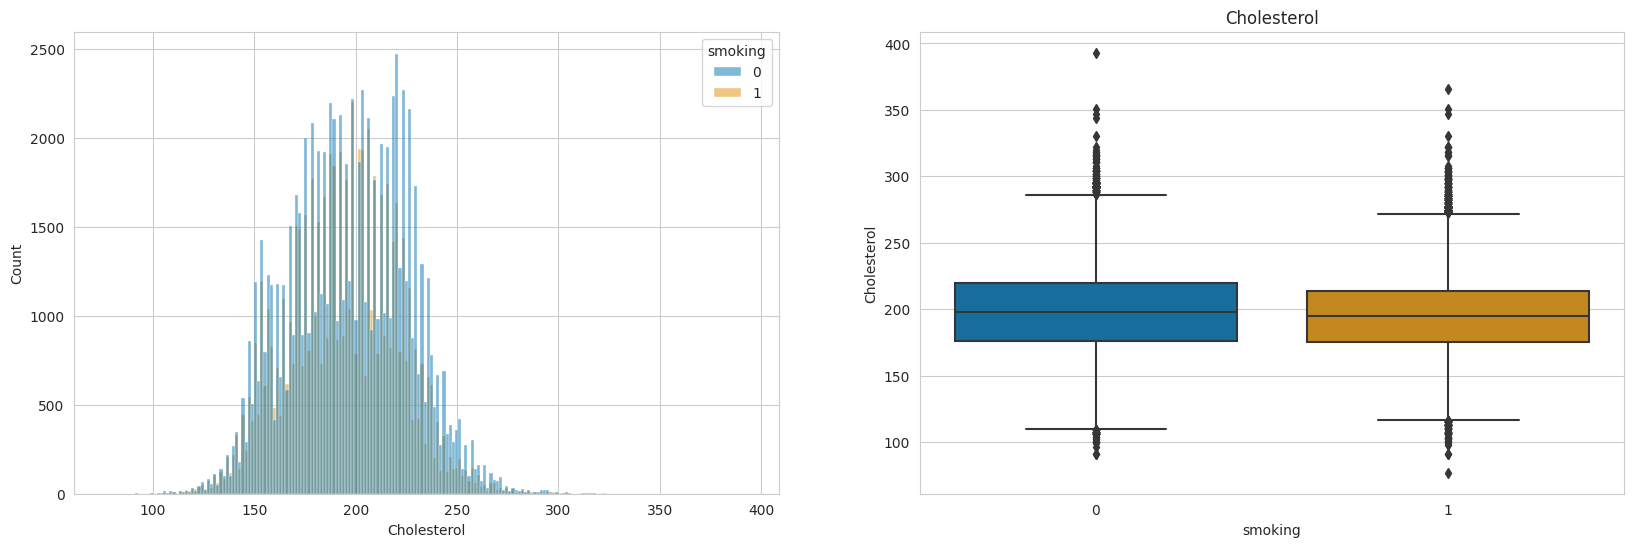

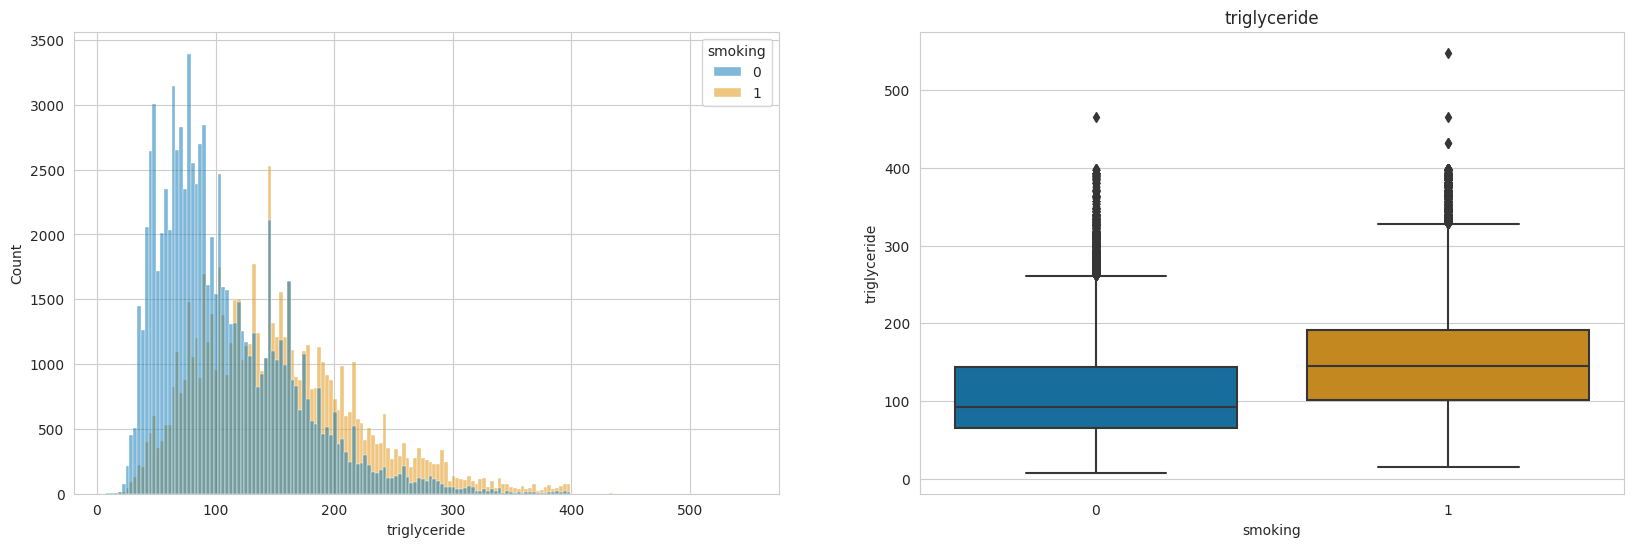

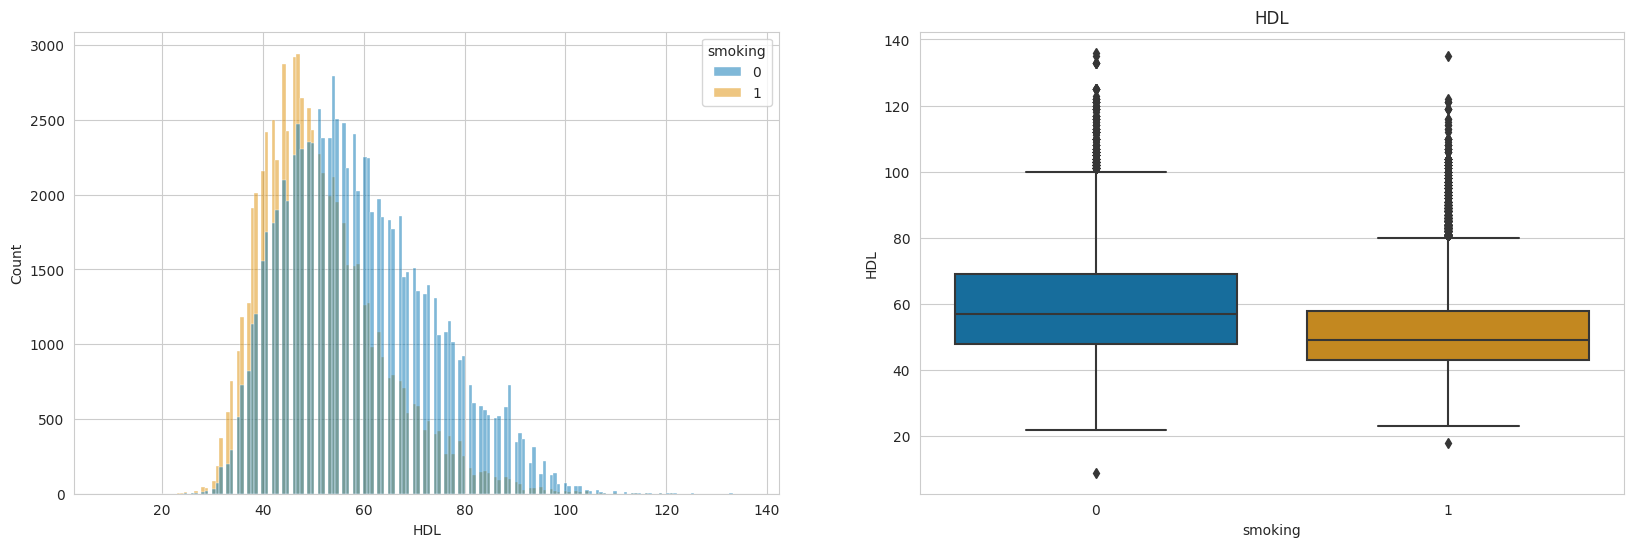

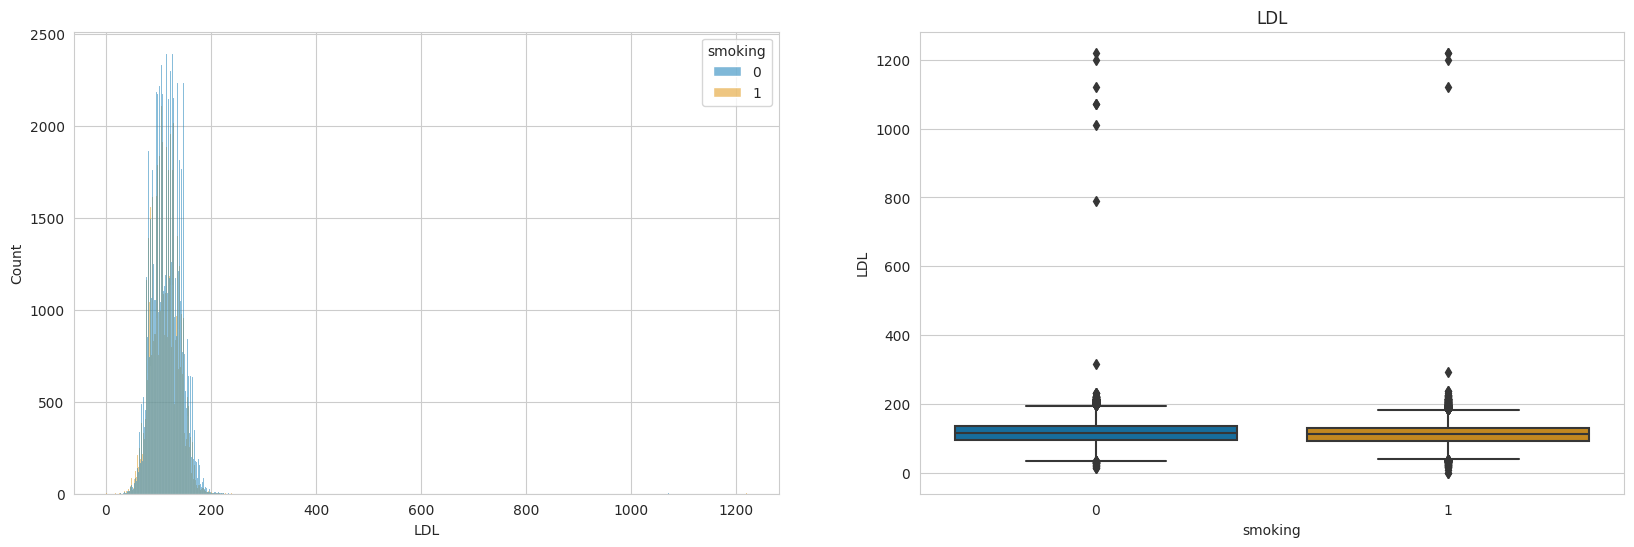

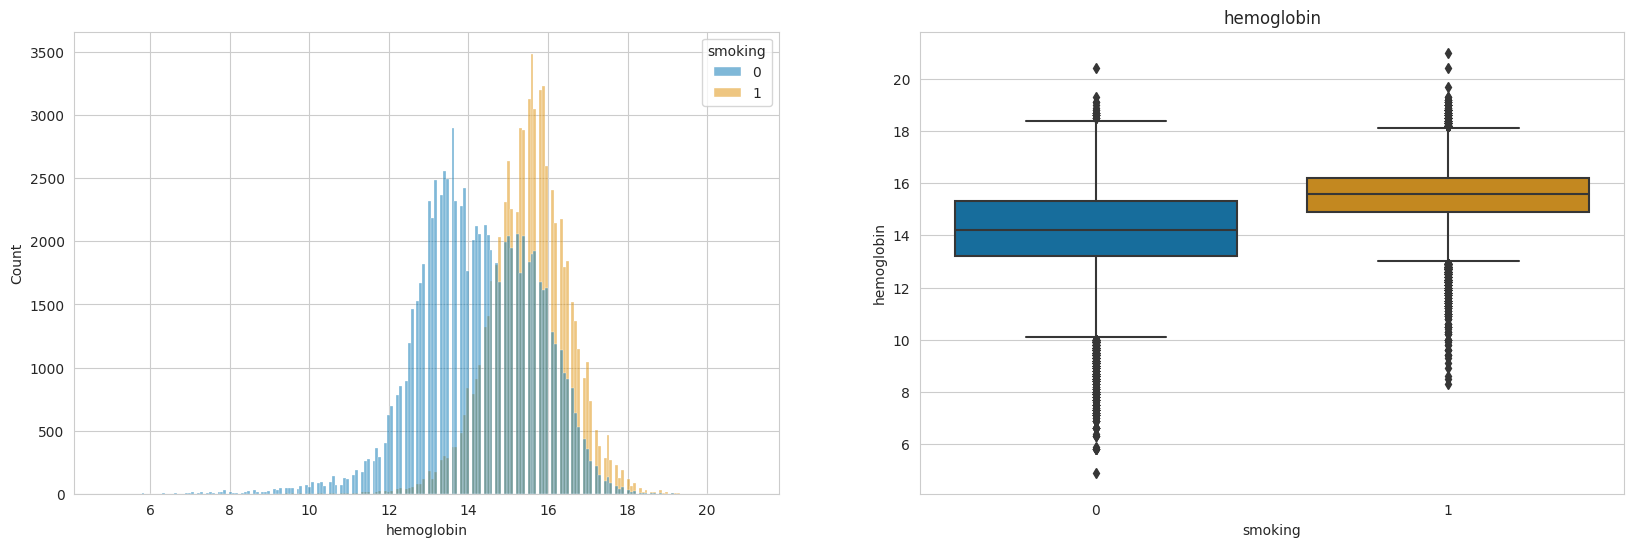

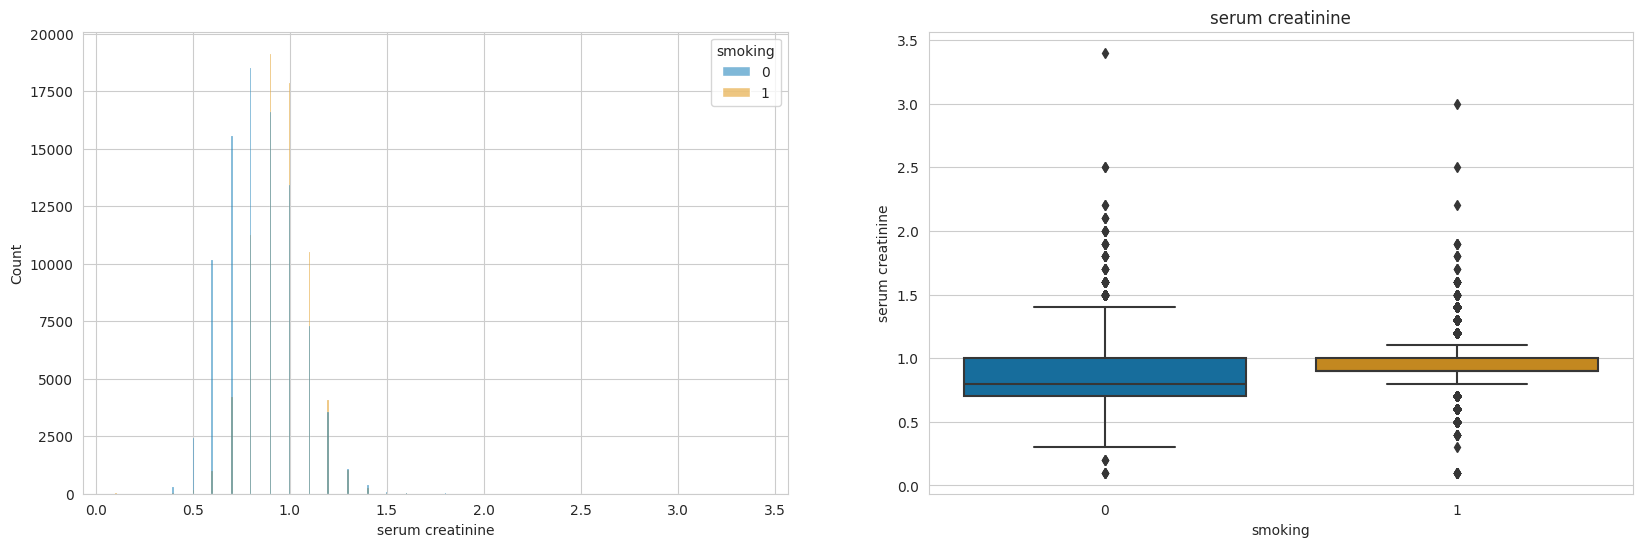

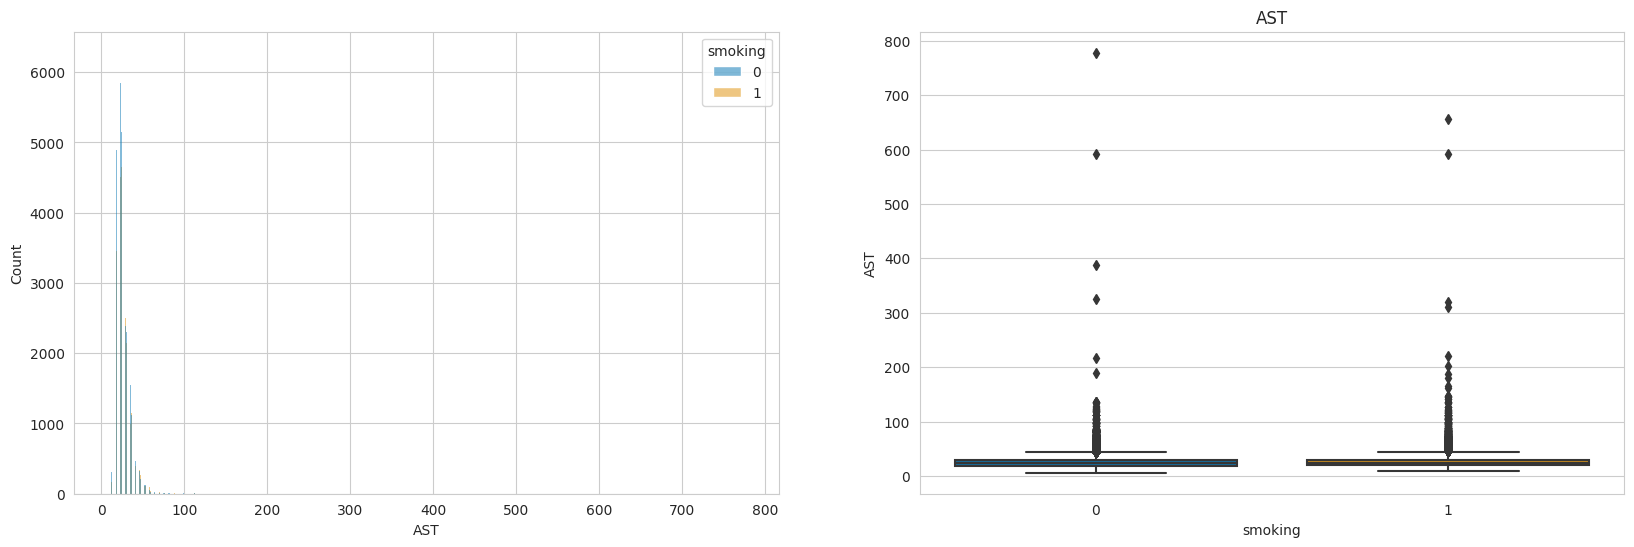

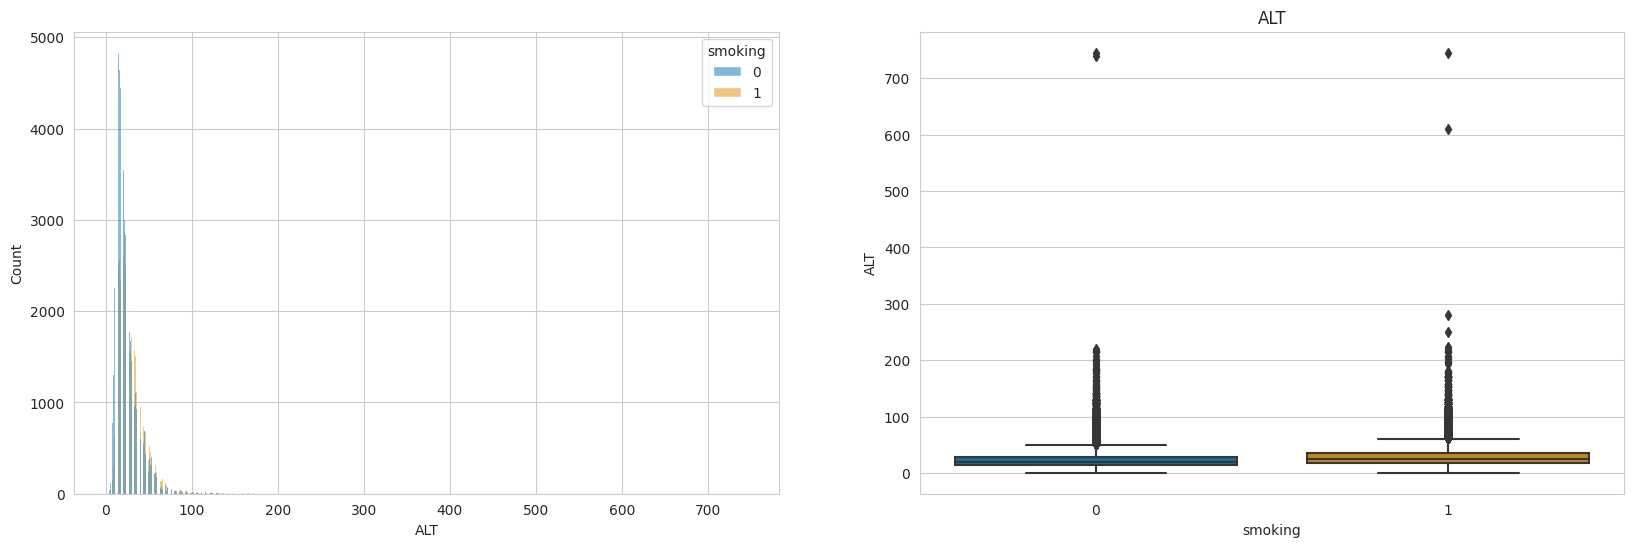

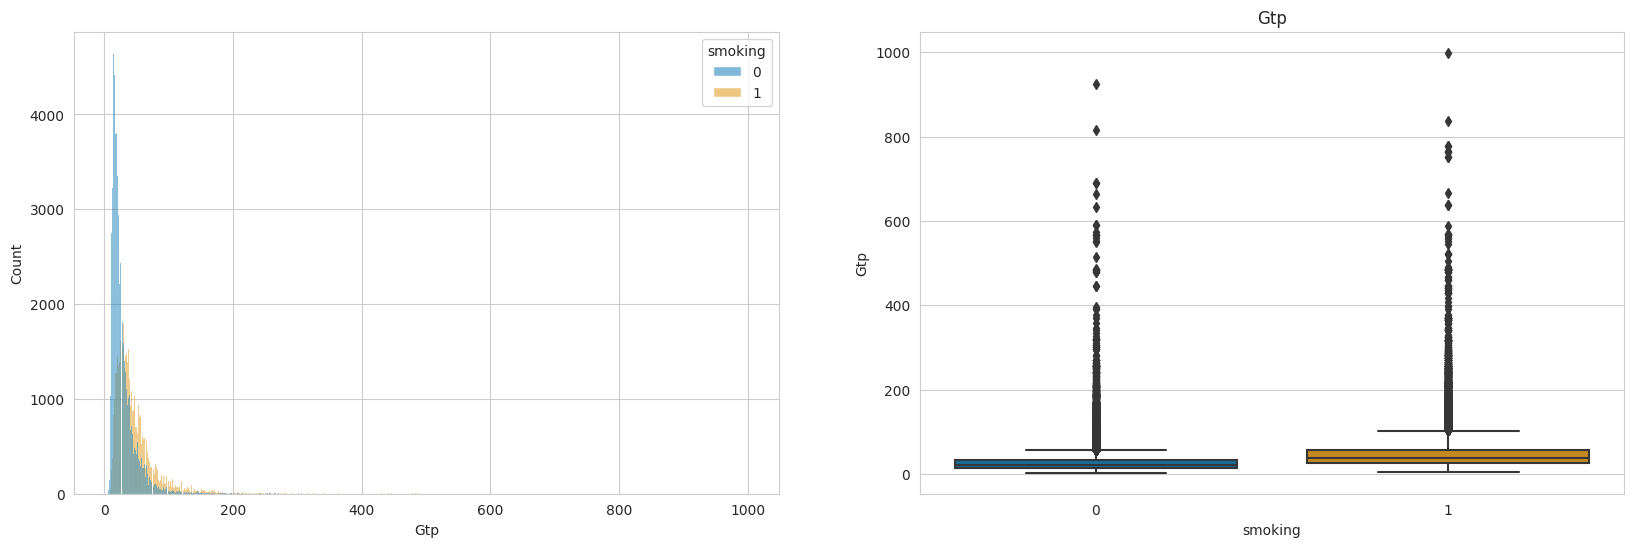

In [39]:
for feat in num_var[:-1]:
    fig, ax = plt.subplots(1, 2, figsize = (20, 6))
    sns.histplot(ax = ax[0], data = train, x = feat, hue = 'smoking')
    sns.boxplot(ax = ax[1], data= train, x = 'smoking', y = feat);
    plt.title(feat)
    plt.show()

# Creating Model

In [40]:
x_train, x_val, y_train, y_val = train_test_split(train[ind_var], train[dep_var], test_size=0.2, random_state=2023)
print("x_train shape:", x_train.shape, "y_train shape:", y_train.shape)
print("x_val shape:", x_val.shape, "y_val shape:", y_val.shape)

x_train shape: (127204, 22) y_train shape: (127204, 1)
x_val shape: (31801, 22) y_val shape: (31801, 1)


In [41]:
from sklearn.preprocessing import StandardScaler

# scale the data with object range of 0-1
scaler = StandardScaler()

x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)

In [42]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(random_state = 2023)

In [52]:
# Parameters
EPOCH = 20
BATCH_SIZE = 64
LOSS = 'binary_crossentropy'
OPTIMIZER = 'sgd'
METRICS = 'accuracy'

In [54]:
model = keras.Sequential([
    keras.layers.Dense(128, activation='relu', input_shape=(x_train.shape[1],)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=METRICS)

In [55]:
history = model.fit(x_train, y_train, epochs=EPOCH, batch_size=BATCH_SIZE, validation_data=(x_val, y_val), verbose=1)

Epoch 1/20
1988/1988 [==============================] - 9s 4ms/step - loss: 0.5160 - accuracy: 0.7302 - val_loss: 0.4647 - val_accuracy: 0.7662
Epoch 2/20
1988/1988 [==============================] - 8s 4ms/step - loss: 0.4713 - accuracy: 0.7620 - val_loss: 0.4572 - val_accuracy: 0.7704
Epoch 3/20
1988/1988 [==============================] - 7s 4ms/step - loss: 0.4656 - accuracy: 0.7657 - val_loss: 0.4540 - val_accuracy: 0.7746
Epoch 4/20
1988/1988 [==============================] - 8s 4ms/step - loss: 0.4621 - accuracy: 0.7676 - val_loss: 0.4520 - val_accuracy: 0.7752
Epoch 5/20
1988/1988 [==============================] - 7s 4ms/step - loss: 0.4597 - accuracy: 0.7699 - val_loss: 0.4504 - val_accuracy: 0.7762
Epoch 6/20
1988/1988 [==============================] - 8s 4ms/step - loss: 0.4582 - accuracy: 0.7706 - val_loss: 0.4495 - val_accuracy: 0.7760
Epoch 7/20
1988/1988 [==============================] - 8s 4ms/step - loss: 0.4570 - accuracy: 0.7714 - val_loss: 0.4495 - val_accuracy:

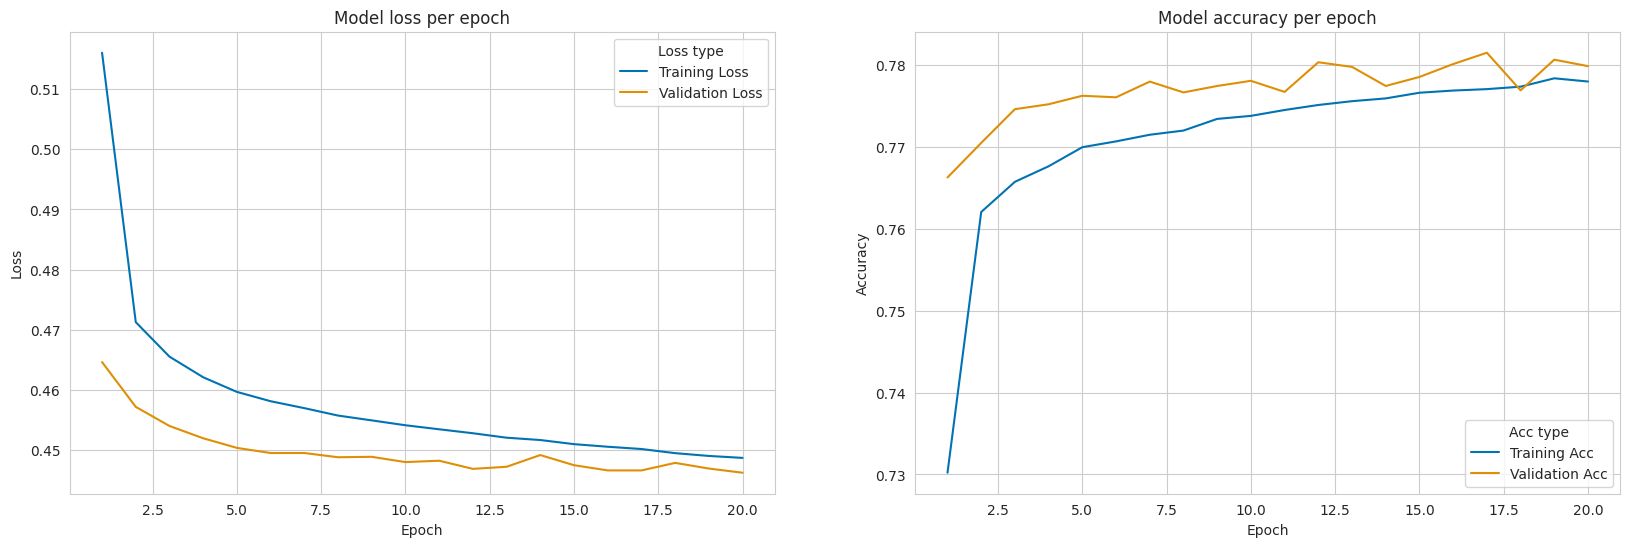

In [56]:
fig, ax = plt.subplots(1, 2, figsize = (20, 6))

loss_train = history.history['loss']
loss_val = history.history['val_loss']
df1 = pd.DataFrame({'Loss': loss_train,'Epoch': [x for x in range(1, EPOCH+1)],'Loss type': ['Training Loss' for x in range (1,EPOCH+1)]})
df2 = pd.DataFrame({'Loss': loss_val,'Epoch': [x for x in range(1, EPOCH+1)],'Loss type': ['Validation Loss' for x in range (1,EPOCH+1)]})

sns.lineplot(ax = ax[0], data = pd.concat([df1, df2]), x = 'Epoch', y= 'Loss', hue = 'Loss type')
ax[0].set_title("Model loss per epoch")

acc_train = history.history['accuracy']
acc_val = history.history['val_accuracy']
df1 = pd.DataFrame({'Accuracy': acc_train,'Epoch': [x for x in range(1, EPOCH+1)],'Acc type': ['Training Acc' for x in range (1,EPOCH+1)]})
df2 = pd.DataFrame({'Accuracy': acc_val,'Epoch': [x for x in range(1, EPOCH+1)],'Acc type': ['Validation Acc' for x in range (1,EPOCH+1)]})

sns.lineplot(ax = ax[1], data = pd.concat([df1, df2]), x = 'Epoch', y= 'Accuracy', hue = 'Acc type')
ax[1].set_title("Model accuracy per epoch")

plt.show()

In [57]:
from sklearn import metrics

#y_pred = model.predict(x_val)
#print("Accuracy:",metrics.accuracy_score(y_val, y_pred))

y_pred = model.predict(x_val)
y_pred_binary = (y_pred > 0.5).astype(int)

accuracy = accuracy_score(y_val, y_pred_binary)
precision = precision_score(y_val, y_pred_binary)
recall = recall_score(y_val, y_pred_binary)
f1 = f1_score(y_val, y_pred_binary)
roc_auc = roc_auc_score(y_val, y_pred)

print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1-Score:', f1)
print('ROC-AUC:', roc_auc)

994/994 [==============================] - 1s 1ms/step
Accuracy: 0.7798182447092858
Precision: 0.7247339567881329
Recall: 0.8043089256316656
F1-Score: 0.7624508074365586
ROC-AUC: 0.8625167897463109


In [58]:
sample_submission = pd.read_csv('/kaggle/input/playground-series-s3e24/sample_submission.csv')
test = pd.read_csv('/kaggle/input/playground-series-s3e24/test.csv')

In [59]:
x_test = scaler.transform(test.drop(columns=['id']))
y_test_pred = model.predict(x_test)

3318/3318 [==============================] - 5s 1ms/step


In [60]:
submission = pd.DataFrame({'id': test['id'], 'smoking': y_test_pred.flatten()})
submission.to_csv('submission.csv', index=False)

In [61]:
submission

,id,smoking
0,159256,0.613512
1,159257,0.160193
2,159258,0.470337
3,159259,0.025946
4,159260,0.571433
...,...,...
106166,265422,0.417222
106167,265423,0.670259
106168,265424,0.516967
106169,265425,0.061981
